<a href="https://colab.research.google.com/github/mingl2000/xlstm-ts/blob/main/notebooks/sp500_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 1**: S&P 500 - Daily Close Prices

---


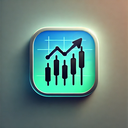

**Note**: Run with T4 GPU in Google Colab! (CUDA is required)

## Constants

**Dataset**: S&P 500 (US)

https://finance.yahoo.com/quote/%5EGSPC/

In [ ]:
# Ticker (check in Yahoo Finance) and custom stock name
TICKER = '^GSPC' # S&P 500 index
STOCK = 'S&P 500'

# Date range (YYYY-MM-DD) and frequency
START_DATE = '2000-01-01'
END_DATE = '2023-12-31'
FREQ = '1d' # daily frequency

FILE_NAME = 'sp500_daily' # custom file name

*   **Train**: 01/2000 - 12/2020
*   **Validation**: 01/2021 - 06/2022
*   **Test**: 07/2022 - 12/2023

In [ ]:
# Train, validation, test split
TRAIN_END_DATE = '2021-01-01'
VAL_END_DATE = '2022-07-01'

## Requirements

In [ ]:
repo_url = 'https://github.com/mingl2000/xlstm-ts.git'

# Clone the repository
!git clone {repo_url}

Cloning into 'xlstm-ts'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 316 (delta 168), reused 230 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (316/316), 8.54 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [ ]:
%cd xlstm-ts

/content/xlstm-ts


NOTE: It can take a few minutes to install all dependencies.

In [ ]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.1 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the 

In [ ]:
# Add the src directory to the Python path
import sys
import os

# Get the path of the current working directory
current_dir = os.getcwd()

# Construct the path to the 'src' directory in the current folder
src_path = os.path.join(current_dir, 'src')

# Add the 'src' directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

In [ ]:
from ml.utils.imports import *

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Optional: Retrieve MORE hourly data (API limitations apply)

(SKIP THIS STEP IF YOU DO NOT NEED HOURLY DATA MORE THAN 2 YEARS OLD)

**Where to find your Tiingo API Token?**

**Step 1: Create a Tiingo account if you have not already.**

You can do so by visit https://api.tiingo.com and clicking “Sign-up” in the top right corner.

**Step 2: Access the API Token Account Page.**

Visit https://api.tiingo.com/account/api/token to see your API Token and copy it below. Do not share it with anybody as this token will identify your usage with your account.

In [ ]:
os.environ['TIINGO_API_KEY'] = '' # Add your Tiingo API key here

## Dataset

In [ ]:
from ml.data.download import download_data
from ml.utils.visualisation import plot_data

### **Optional: Read local files**

If you want to read the given data from the experiment, UNCOMMENT this code snippet and COMMENT OUT the regular download to proceed.

(NOTE: The regular download will retrieve the exact same data by default, you can experiment with the constants at the top of the file to change it)

In [ ]:
'''
# Read the CSV file and set the "Date" column as the index
file_path = os.path.join('data', 'datasets', FILE_NAME + '.csv')
df = pd.read_csv(file_path, header=0, index_col='Date')
# Convert the index to a datetime object
df.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
'''

'\n# Read the CSV file and set the "Date" column as the index\nfile_path = os.path.join(\'data\', \'datasets\', FILE_NAME + \'.csv\')\ndf = pd.read_csv(file_path, header=0, index_col=\'Date\')\n# Convert the index to a datetime object\ndf.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))\n'

### Download data

- **Tiingo**: If the frequency is hourly and the starting date is more than 2 years before, the Tiingo API will be used. You need to enter the API key to proceed (the steps are explained above). Note that restrictive API limitations apply.

- **Yahoo Finance**: In all other cases, Yahoo Finance will be used. There's no need to enter an API key to download data from it, and there are no API restrictions with responsible usage.

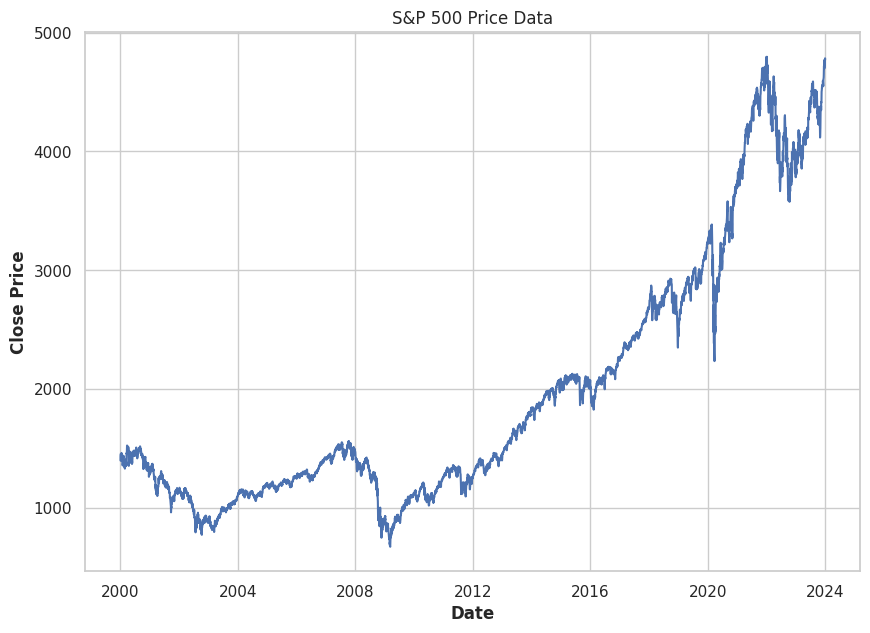

In [ ]:
# Download the data
df = download_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, freq=FREQ)

# Plot the raw data
plot_data(df, STOCK)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [ ]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 46.28 dB


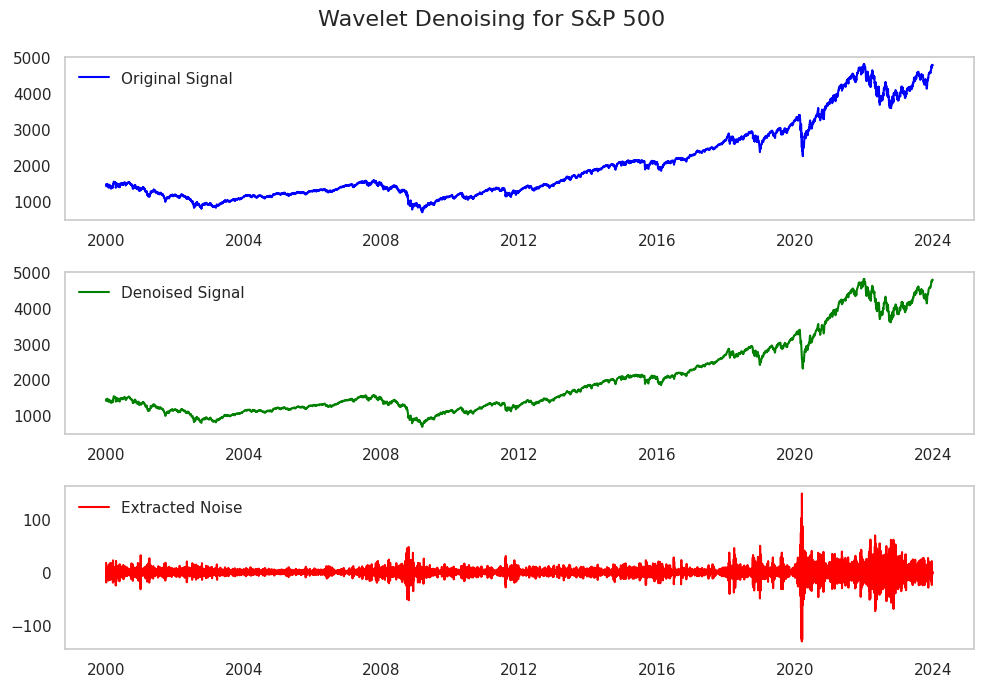

In [ ]:
# Apply denoising
df['Close_denoised'] = wavelet_denoising(df['Close'])
df['Noise'] = df['Close'] - df['Close_denoised']

plot_wavelet_denoising(df, STOCK)

### Process dates

In [ ]:
from ml.data.preprocessing import process_dates

In [ ]:
# Convert the Date column to time zone-naive datetime
df = process_dates(df)

### Model-specific preprocessing

#### For darts library models

##### Convert to darts TimeSeries

**Darts Library**:

- Paper: https://www.jmlr.org/papers/v23/21-1177.html
- Documentation: https://unit8co.github.io/darts/README.html#
- Repository: https://github.com/unit8co/darts

In [ ]:
from ml.models.darts.preprocessing import convert_to_ts_daily

In [ ]:
series, series_denoised = convert_to_ts_daily(df)
series_denoised

<TimeSeries (DataArray) (Date: 6037, component: 1, sample: 1)> Size: 48kB
array([[[1437.6764069 ]],

       [[1419.02923629]],

       [[1395.54938238]],

       ...,

       [[4781.45492258]],

       [[4782.76373207]],

       [[4771.75571991]]])
Coordinates:
  * Date       (Date) datetime64[ns] 48kB 2000-01-03 2000-01-04 ... 2023-12-29
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Train, Validation and Test split

In [ ]:
from ml.models.darts.preprocessing import split_train_val_test_darts

In [ ]:
# Transform the string dates into datetime objects
TRAIN_END_DATE = datetime.datetime.strptime(TRAIN_END_DATE, '%Y-%m-%d')
VAL_END_DATE = datetime.datetime.strptime(VAL_END_DATE, '%Y-%m-%d')

In [ ]:
train, val, test = split_train_val_test_darts(series, TRAIN_END_DATE, VAL_END_DATE)
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(series_denoised, TRAIN_END_DATE, VAL_END_DATE)

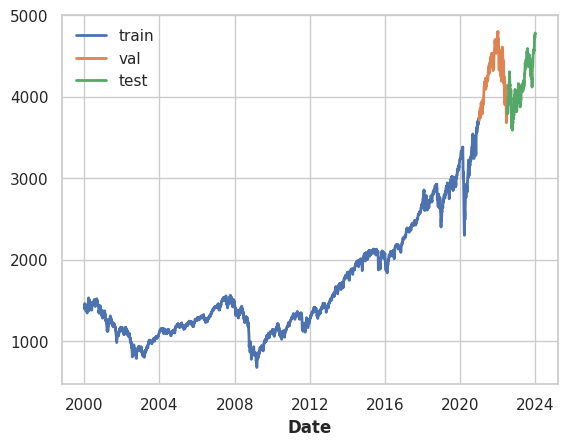

In [ ]:
train_denoised.plot(label="train");
val_denoised.plot(label="val");
test_denoised.plot(label="test");

##### Normalise data

In [ ]:
from ml.models.darts.preprocessing import normalise_split_data_darts

In [ ]:
train, val, test, scaler_darts = normalise_split_data_darts(train, val, test)
train_denoised, val_denoised, test_denoised, scaler_darts_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised)

#### For the proposed model

##### Normalise data

In [ ]:
from ml.models.xlstm_ts.preprocessing import normalise_data_xlstm

In [ ]:
close_scaled, scaler = normalise_data_xlstm(df['Close'].values)

In [ ]:
close_scaled_denoised, scaler_denoised = normalise_data_xlstm(df['Close_denoised'].values)

##### Create sequences

In [ ]:
from ml.models.xlstm_ts.preprocessing import create_sequences

In [ ]:
X, y, dates = create_sequences(close_scaled, df.index)

In [ ]:
X_denoised, y_denoised, _ = create_sequences(close_scaled_denoised, df.index)

##### Train, Validation and Test split

In [ ]:
from ml.models.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([5134, 150, 1])
train y shape: torch.Size([5134, 1])
val X shape: torch.Size([376, 150, 1])
val y shape: torch.Size([376, 1])
test X shape: torch.Size([377, 150, 1])
test y shape: torch.Size([377, 1])


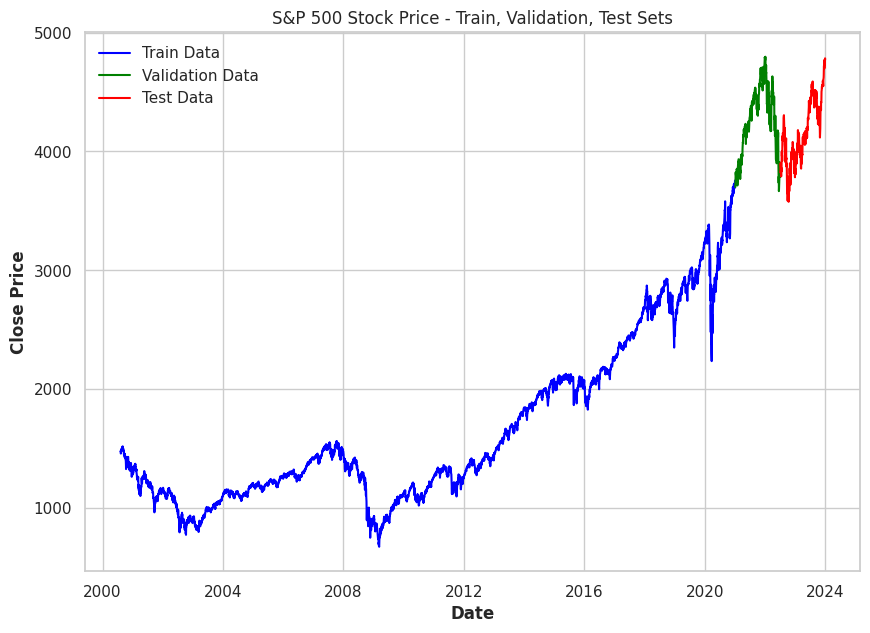

In [ ]:
train_X, train_y, train_dates, val_X, val_y, val_dates, test_X, test_y, test_dates = split_train_val_test_xlstm(X, y, dates, TRAIN_END_DATE, VAL_END_DATE, scaler, STOCK)

train X shape: torch.Size([5134, 150, 1])
train y shape: torch.Size([5134, 1])
val X shape: torch.Size([376, 150, 1])
val y shape: torch.Size([376, 1])
test X shape: torch.Size([377, 150, 1])
test y shape: torch.Size([377, 1])


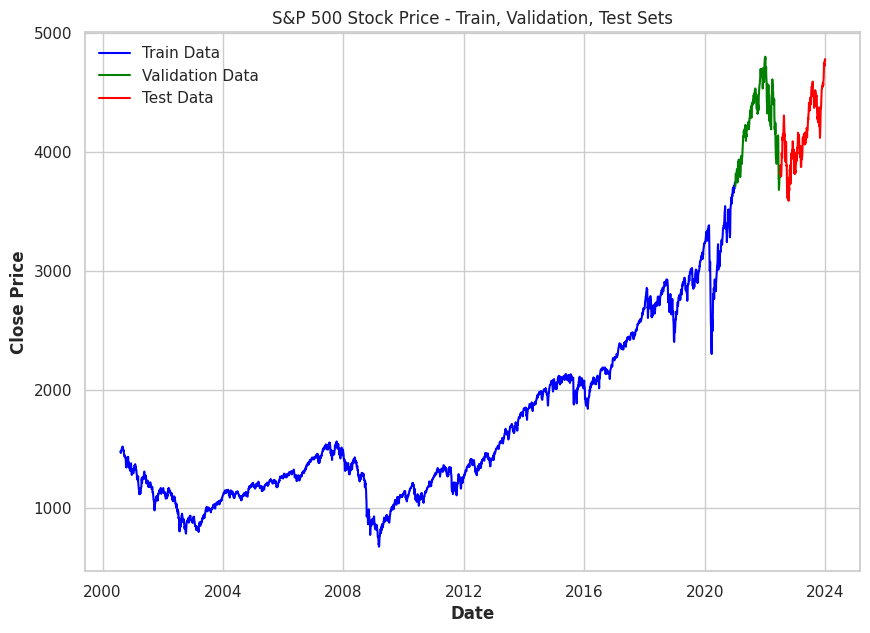

In [ ]:
train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, _ = split_train_val_test_xlstm(X_denoised, y_denoised, dates, TRAIN_END_DATE, VAL_END_DATE, scaler_denoised, STOCK)

## Models

In [ ]:
from ml.models.shared.directional_prediction import *
from ml.models.shared.metrics import *
from ml.models.shared.visualisation import *
from ml.models.darts.darts_models import *
from ml.models.darts.training import *

In [ ]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### TCN

**References**:

- Paper (2018): https://doi.org/10.48550/arXiv.1803.01271
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/05-TCN-examples.html

**Not denoised**

Price Prediction Metrics:

TCN (Original) | MAE: 29.03
TCN (Original) | MSE: 1336.56
TCN (Original) | RMSE: 36.56
TCN (Original) | RMSSE: 1.01
TCN (Original) | MAPE: 0.69%
TCN (Original) | MASE: 1.02
TCN (Original) | R2: 0.98


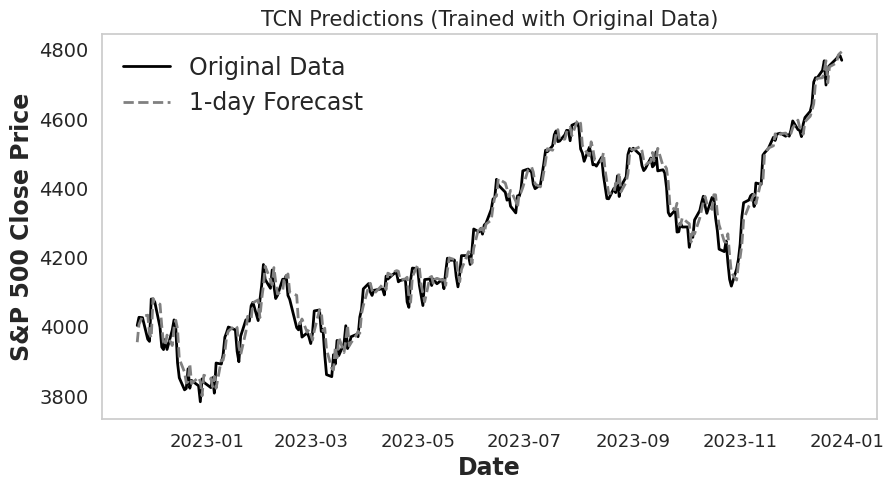

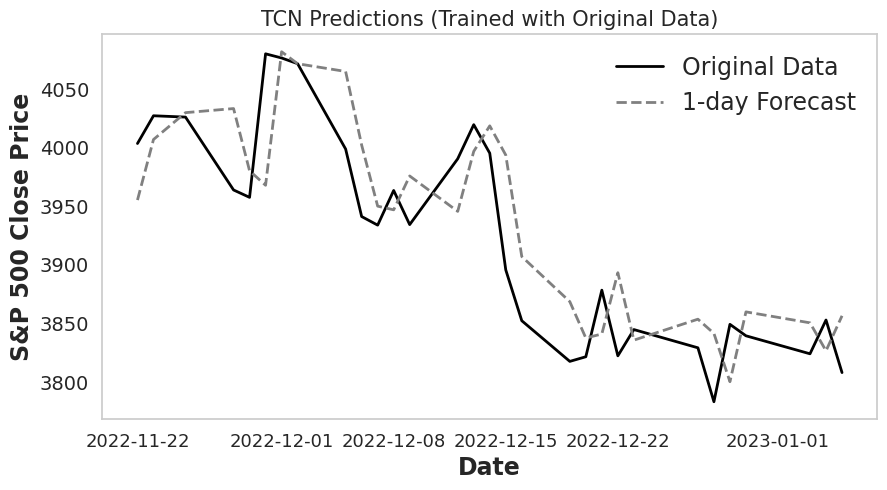


Directional Movement Metrics:

TCN (Original) | Train Accuracy: 47.83%
TCN (Original) | Validation Accuracy: 49.09%
TCN (Original) | Test Accuracy: 49.64%
TCN (Original) | Recall: 53.42%
TCN (Original) | Precision (Rise): 52.35%
TCN (Original) | Precision (Fall): 46.46%
TCN (Original) | F1 Score: 52.88%


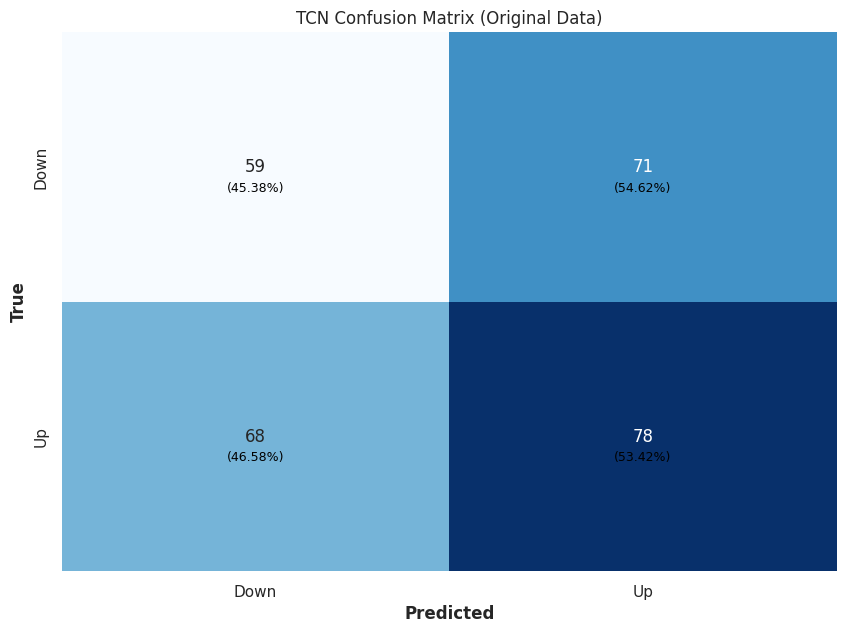

In [ ]:
model = get_model_tcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

TCN (Denoised) | MAE: 30.01
TCN (Denoised) | MSE: 1333.10
TCN (Denoised) | RMSE: 36.51
TCN (Denoised) | RMSSE: 1.01
TCN (Denoised) | MAPE: 0.71%
TCN (Denoised) | MASE: 1.06
TCN (Denoised) | R2: 0.98


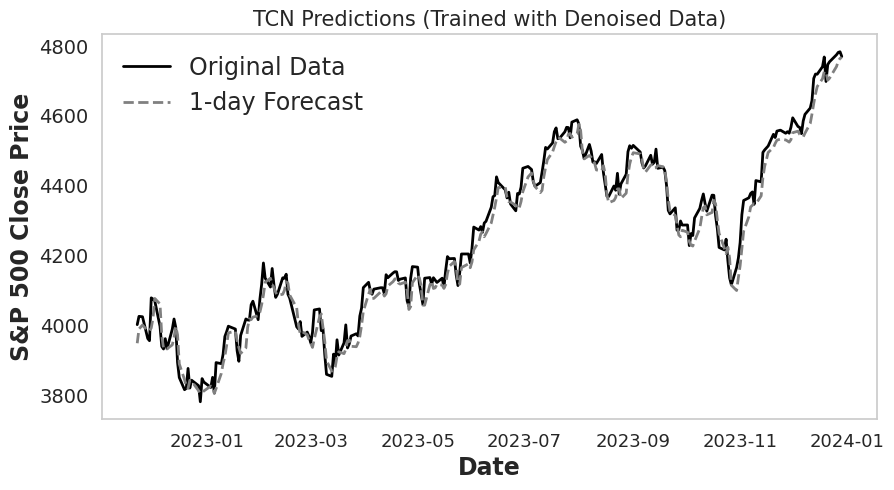

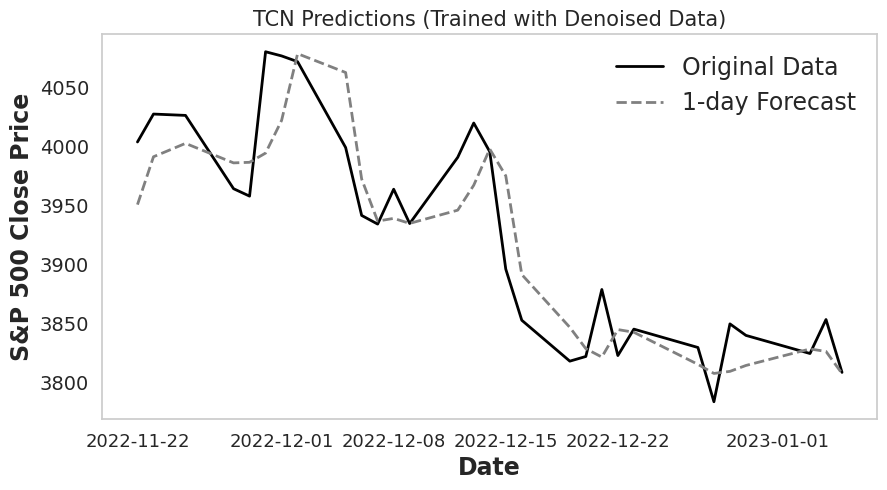


Directional Movement Metrics:

TCN (Denoised) | Train Accuracy: 64.23%
TCN (Denoised) | Validation Accuracy: 65.82%
TCN (Denoised) | Test Accuracy: 63.41%
TCN (Denoised) | Recall: 69.86%
TCN (Denoised) | Precision (Rise): 64.15%
TCN (Denoised) | Precision (Fall): 62.39%
TCN (Denoised) | F1 Score: 66.89%


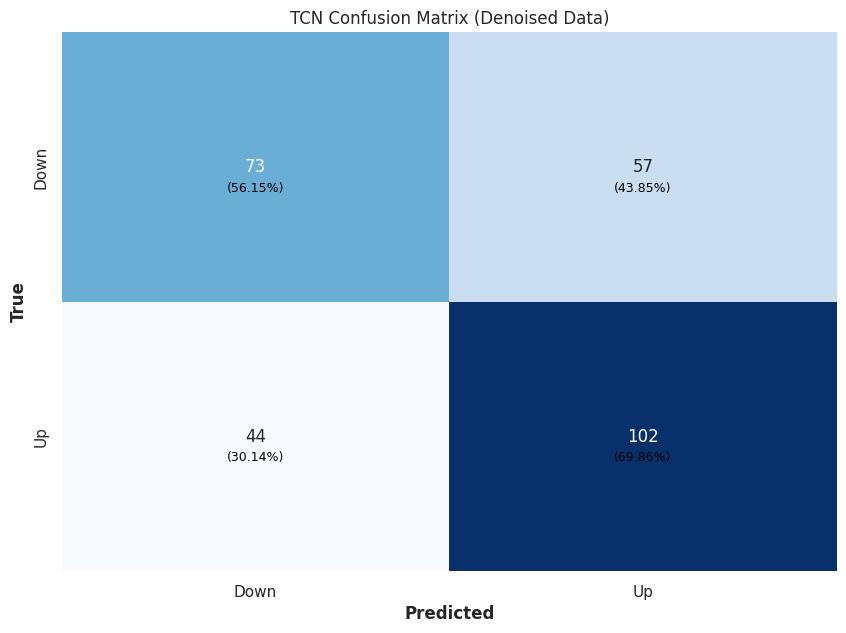

In [ ]:
model = get_model_tcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### DeepTCN

**References**:

- Paper (2020): https://doi.org/10.48550/arXiv.1906.04397
- Code (same as TCN): https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html

**Not denoised**

Price Prediction Metrics:

DeepTCN (Original) | MAE: 50.08
DeepTCN (Original) | MSE: 3471.25
DeepTCN (Original) | RMSE: 58.92
DeepTCN (Original) | RMSSE: 1.62
DeepTCN (Original) | MAPE: 1.18%
DeepTCN (Original) | MASE: 1.76
DeepTCN (Original) | R2: 0.94


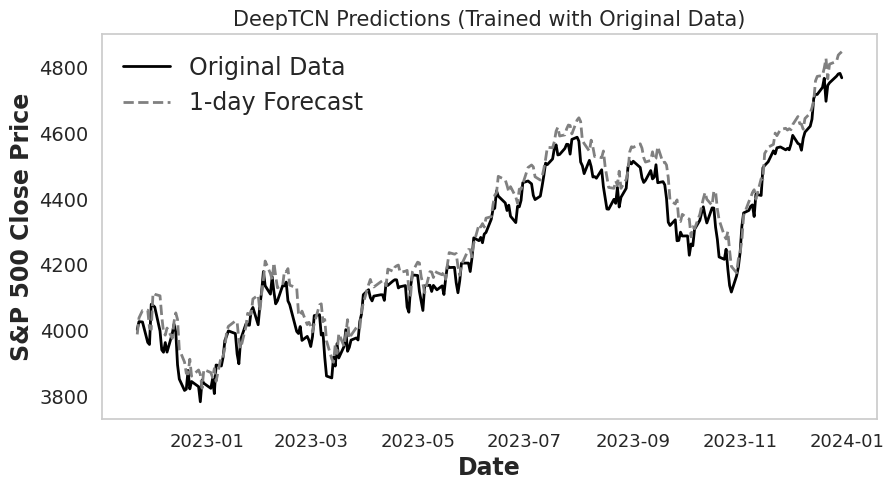

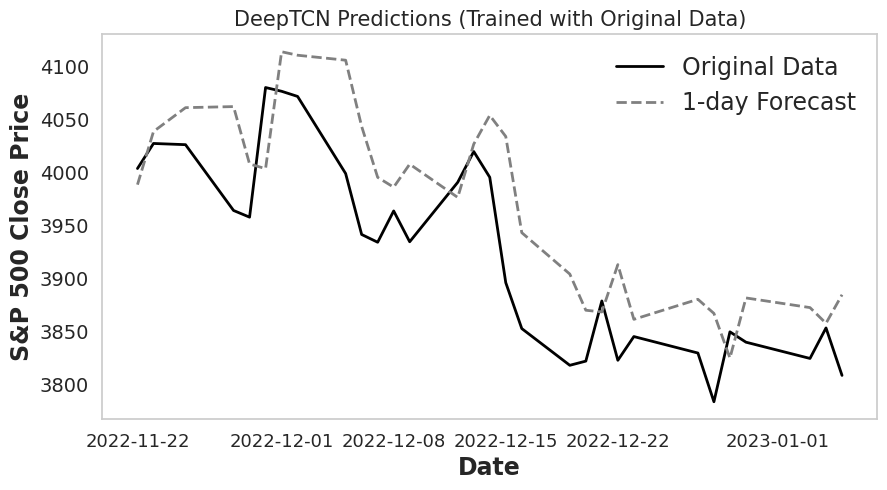


Directional Movement Metrics:

DeepTCN (Original) | Train Accuracy: 47.06%
DeepTCN (Original) | Validation Accuracy: 50.55%
DeepTCN (Original) | Test Accuracy: 48.55%
DeepTCN (Original) | Recall: 51.37%
DeepTCN (Original) | Precision (Rise): 51.37%
DeepTCN (Original) | Precision (Fall): 45.38%
DeepTCN (Original) | F1 Score: 51.37%


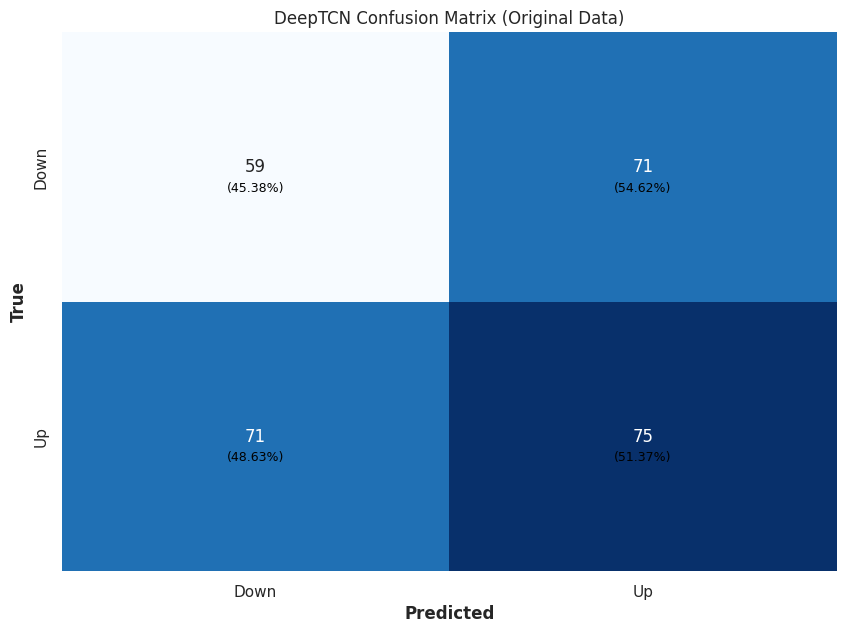

In [ ]:
model = get_model_deeptcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

DeepTCN (Denoised) | MAE: 54.97
DeepTCN (Denoised) | MSE: 3924.06
DeepTCN (Denoised) | RMSE: 62.64
DeepTCN (Denoised) | RMSSE: 1.73
DeepTCN (Denoised) | MAPE: 1.29%
DeepTCN (Denoised) | MASE: 1.94
DeepTCN (Denoised) | R2: 0.93


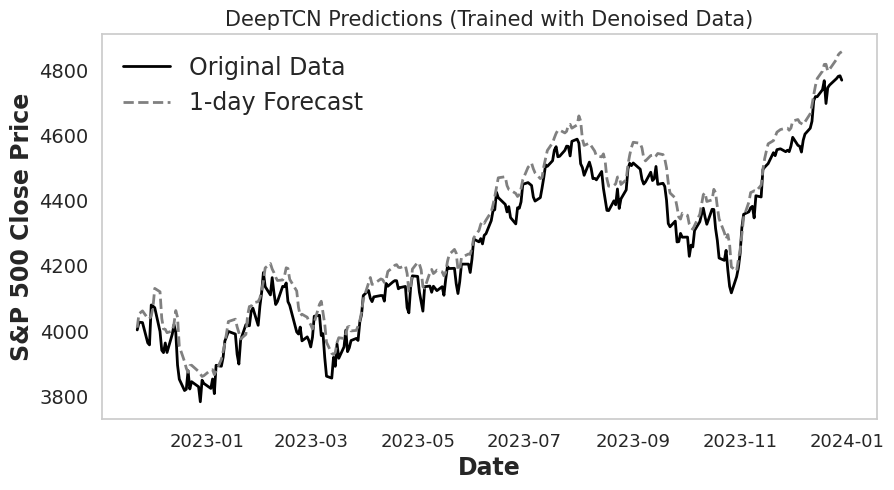

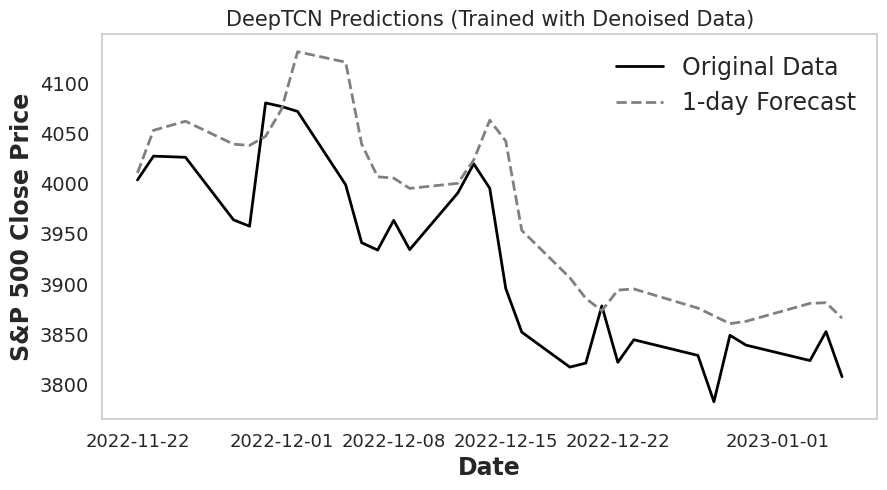


Directional Movement Metrics:

DeepTCN (Denoised) | Train Accuracy: 64.65%
DeepTCN (Denoised) | Validation Accuracy: 65.45%
DeepTCN (Denoised) | Test Accuracy: 63.77%
DeepTCN (Denoised) | Recall: 71.23%
DeepTCN (Denoised) | Precision (Rise): 64.20%
DeepTCN (Denoised) | Precision (Fall): 63.16%
DeepTCN (Denoised) | F1 Score: 67.53%


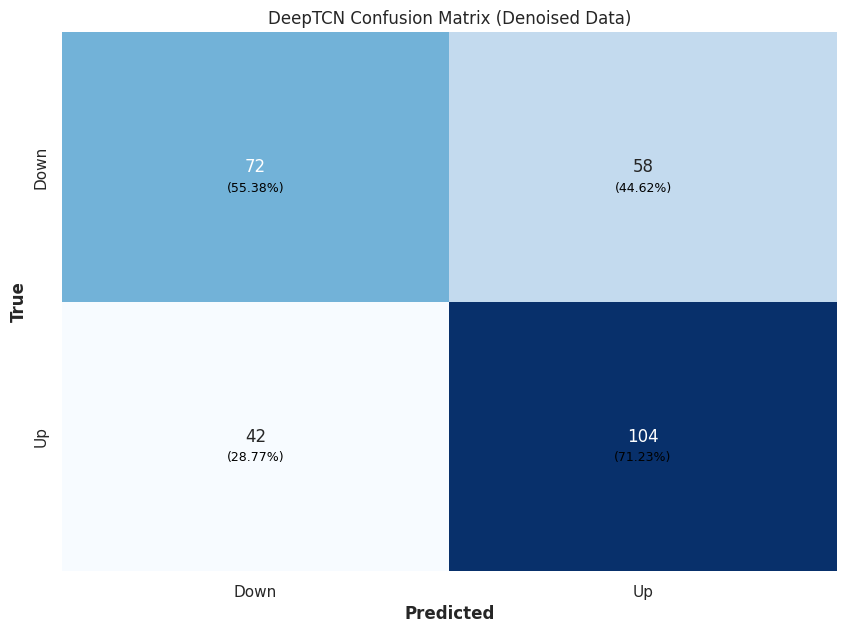

In [ ]:
model = get_model_deeptcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-BEATS

**References**:
- Paper (2020): https://doi.org/10.48550/arXiv.1905.10437
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nbeats.py
- Darts documentation: https://unit8co.github.io/darts/examples/07-NBEATS-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 50.18
N-BEATS (Original) | MSE: 4029.71
N-BEATS (Original) | RMSE: 63.48
N-BEATS (Original) | RMSSE: 1.75
N-BEATS (Original) | MAPE: 1.19%
N-BEATS (Original) | MASE: 1.77
N-BEATS (Original) | R2: 0.93


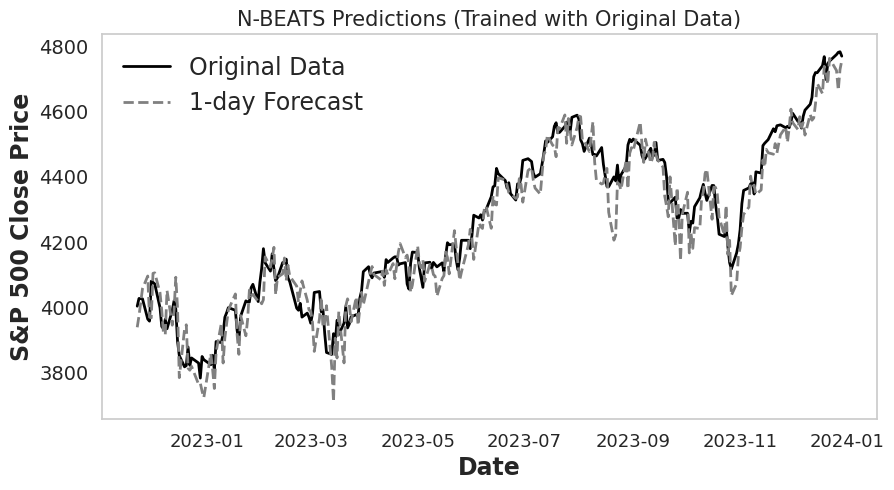

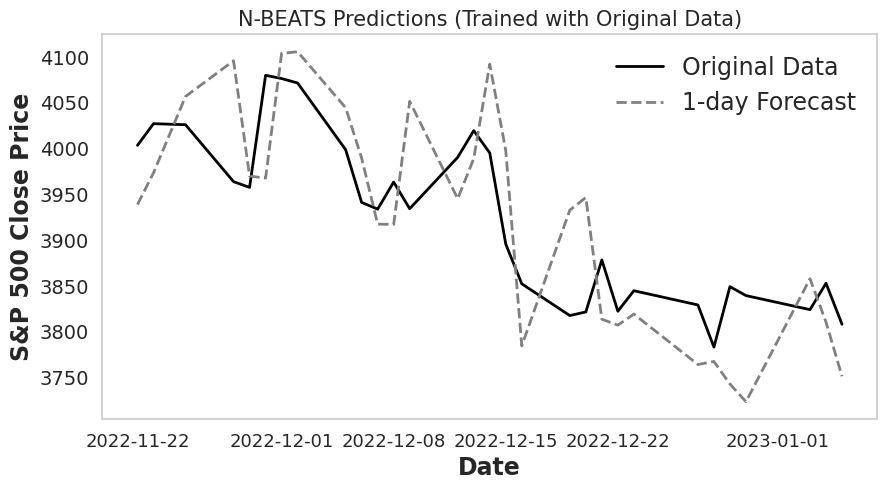


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 50.03%
N-BEATS (Original) | Validation Accuracy: 57.82%
N-BEATS (Original) | Test Accuracy: 48.91%
N-BEATS (Original) | Recall: 48.63%
N-BEATS (Original) | Precision (Rise): 51.82%
N-BEATS (Original) | Precision (Fall): 46.04%
N-BEATS (Original) | F1 Score: 50.18%


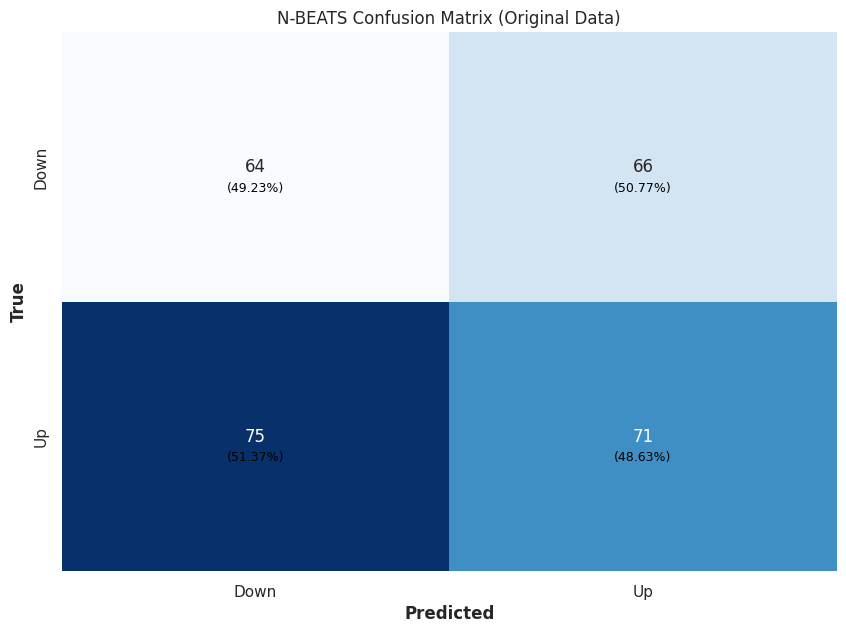

In [ ]:
model = get_model_nbeats()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Denoised) | MAE: 32.14
N-BEATS (Denoised) | MSE: 1666.18
N-BEATS (Denoised) | RMSE: 40.82
N-BEATS (Denoised) | RMSSE: 1.13
N-BEATS (Denoised) | MAPE: 0.76%
N-BEATS (Denoised) | MASE: 1.13
N-BEATS (Denoised) | R2: 0.97


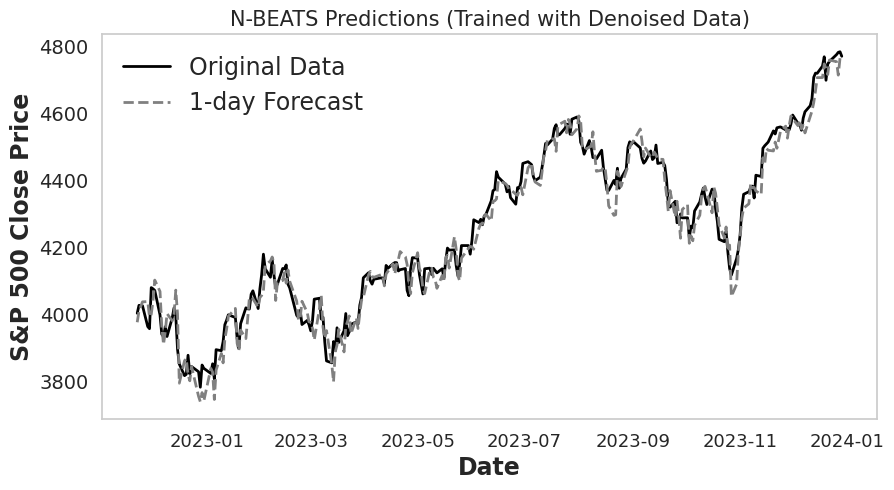

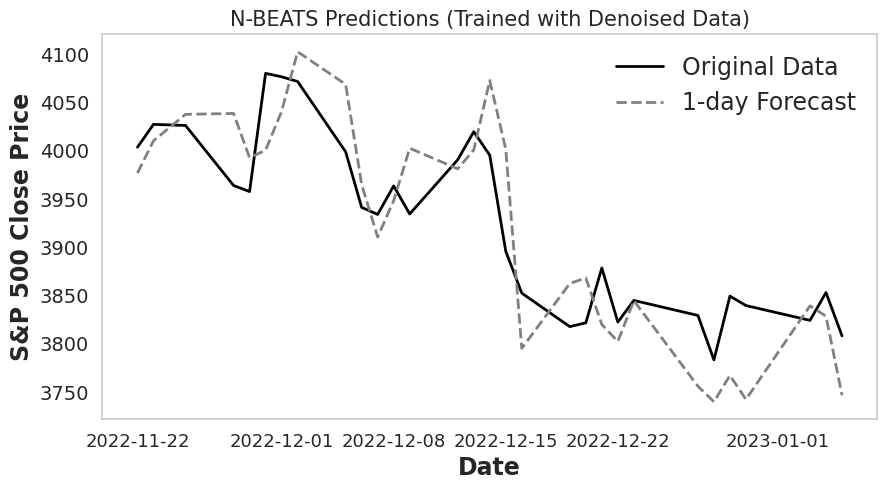


Directional Movement Metrics:

N-BEATS (Denoised) | Train Accuracy: 58.56%
N-BEATS (Denoised) | Validation Accuracy: 63.64%
N-BEATS (Denoised) | Test Accuracy: 59.78%
N-BEATS (Denoised) | Recall: 62.33%
N-BEATS (Denoised) | Precision (Rise): 61.90%
N-BEATS (Denoised) | Precision (Fall): 57.36%
N-BEATS (Denoised) | F1 Score: 62.12%


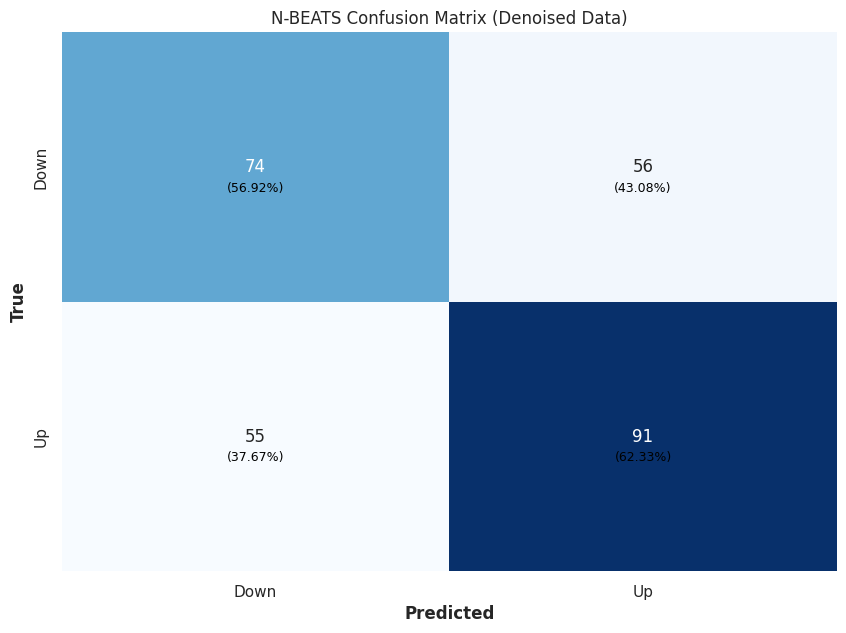

In [ ]:
model = get_model_nbeats()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TFT

Temporal Fusion Transformer Model

**References**:

- Paper (2021): https://doi.org/10.1016/j.ijforecast.2021.03.012
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tft_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/13-TFT-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Original) | MAE: 52.56
TFT (Original) | MSE: 4924.10
TFT (Original) | RMSE: 70.17
TFT (Original) | RMSSE: 1.93
TFT (Original) | MAPE: 1.25%
TFT (Original) | MASE: 1.85
TFT (Original) | R2: 0.92


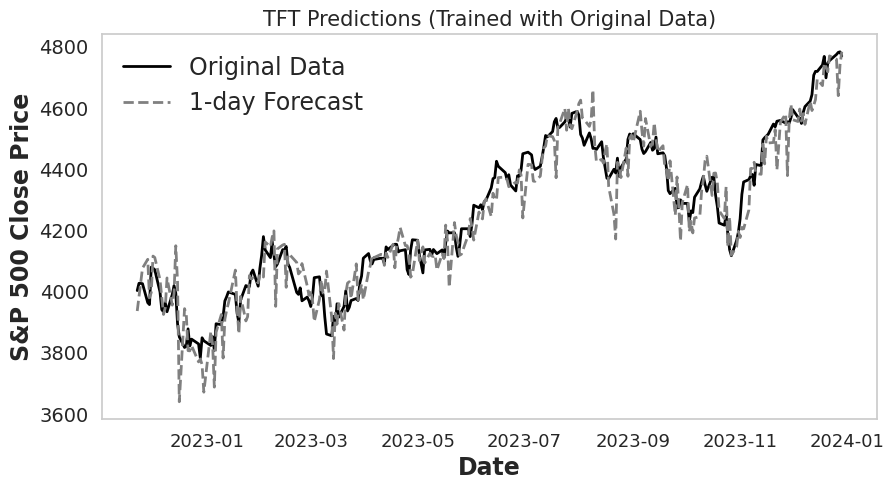

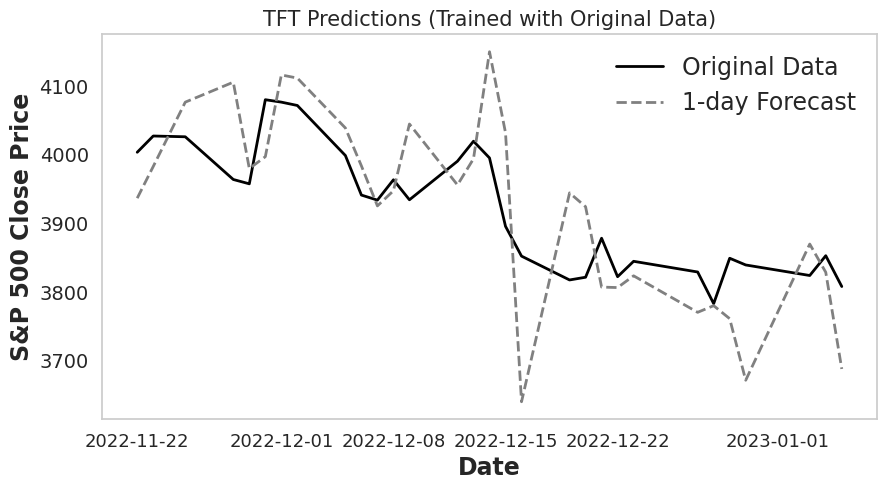


Directional Movement Metrics:

TFT (Original) | Train Accuracy: 48.31%
TFT (Original) | Validation Accuracy: 59.27%
TFT (Original) | Test Accuracy: 51.09%
TFT (Original) | Recall: 52.74%
TFT (Original) | Precision (Rise): 53.85%
TFT (Original) | Precision (Fall): 48.12%
TFT (Original) | F1 Score: 53.29%


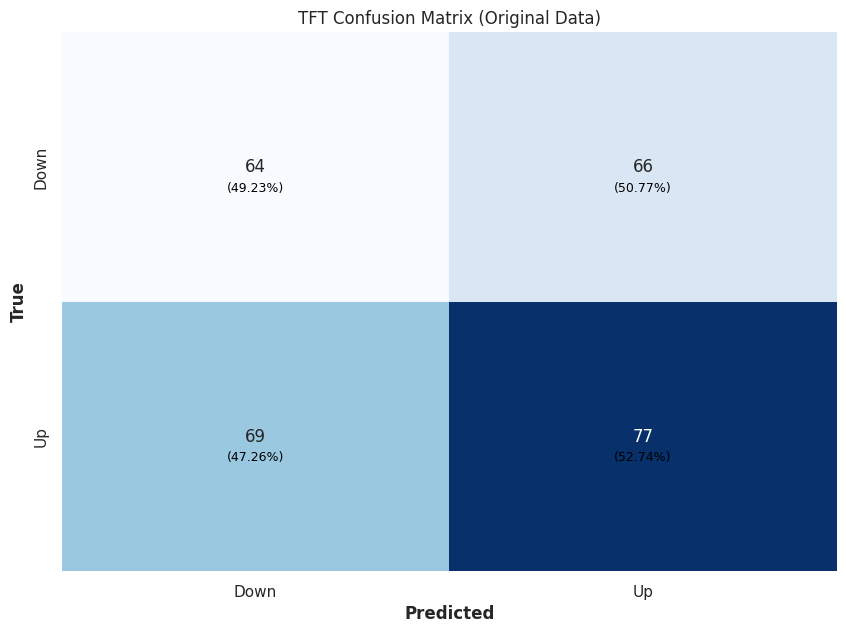

In [ ]:
model = get_model_tft()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Denoised) | MAE: 47.97
TFT (Denoised) | MSE: 4100.21
TFT (Denoised) | RMSE: 64.03
TFT (Denoised) | RMSSE: 1.77
TFT (Denoised) | MAPE: 1.14%
TFT (Denoised) | MASE: 1.69
TFT (Denoised) | R2: 0.93


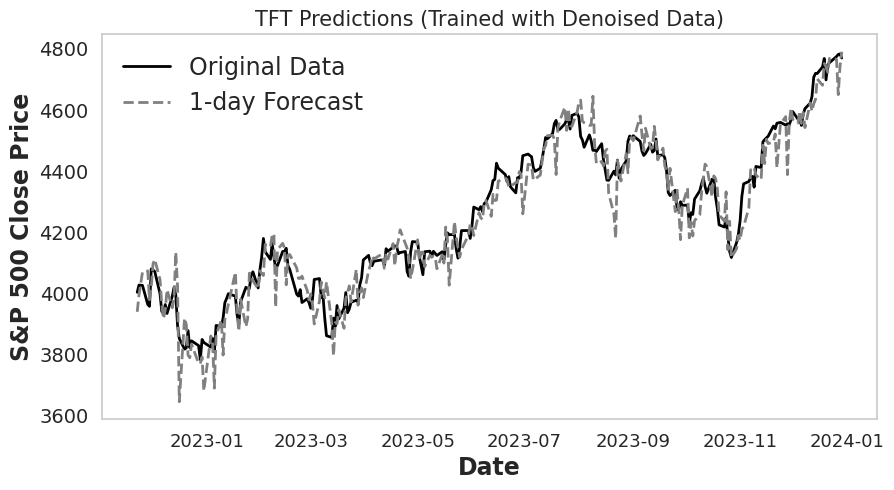

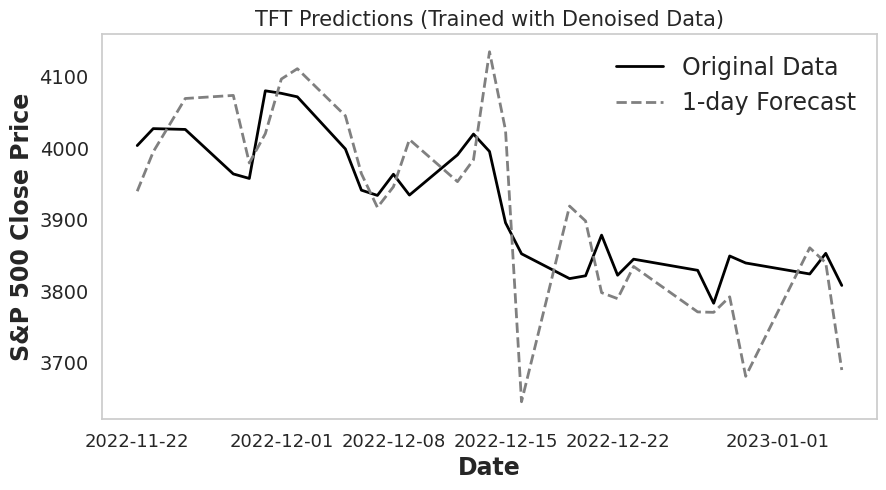


Directional Movement Metrics:

TFT (Denoised) | Train Accuracy: 52.02%
TFT (Denoised) | Validation Accuracy: 60.36%
TFT (Denoised) | Test Accuracy: 53.26%
TFT (Denoised) | Recall: 54.79%
TFT (Denoised) | Precision (Rise): 55.94%
TFT (Denoised) | Precision (Fall): 50.38%
TFT (Denoised) | F1 Score: 55.36%


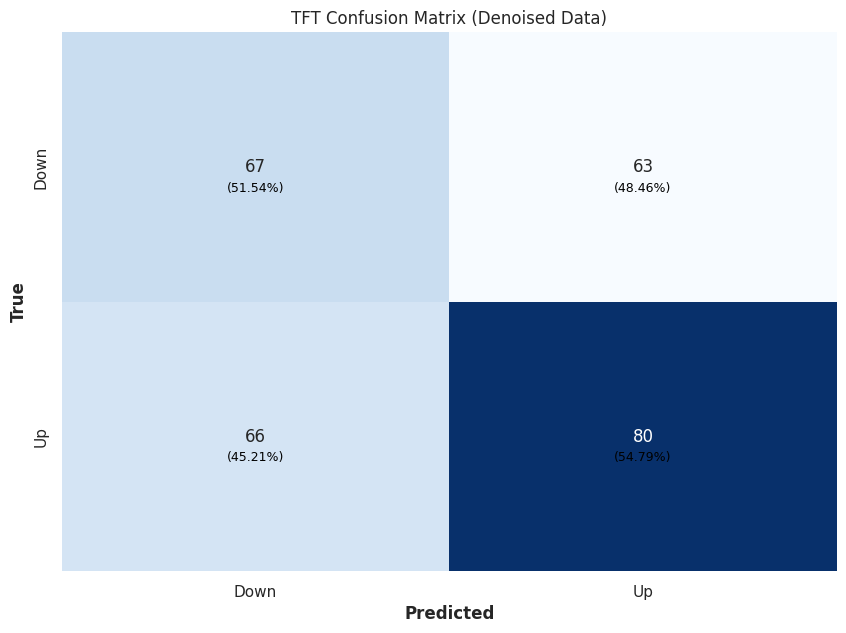

In [ ]:
model = get_model_tft()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TiDE

TimeSeries Dense Encoder Model

**References**:
- Paper (2024): https://doi.org/10.48550/arXiv.2304.08424
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tide_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**+RIN**

Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift

- Paper: https://openreview.net/forum?id=cGDAkQo1C0p

**Not denoised**

Price Prediction Metrics:

TiDE (Original) | MAE: 31.43
TiDE (Original) | MSE: 1512.92
TiDE (Original) | RMSE: 38.90
TiDE (Original) | RMSSE: 1.07
TiDE (Original) | MAPE: 0.75%
TiDE (Original) | MASE: 1.11
TiDE (Original) | R2: 0.97


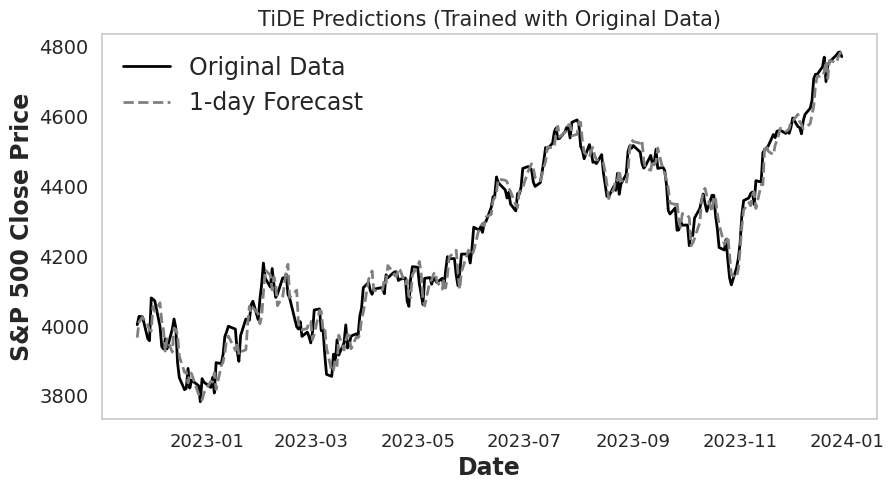

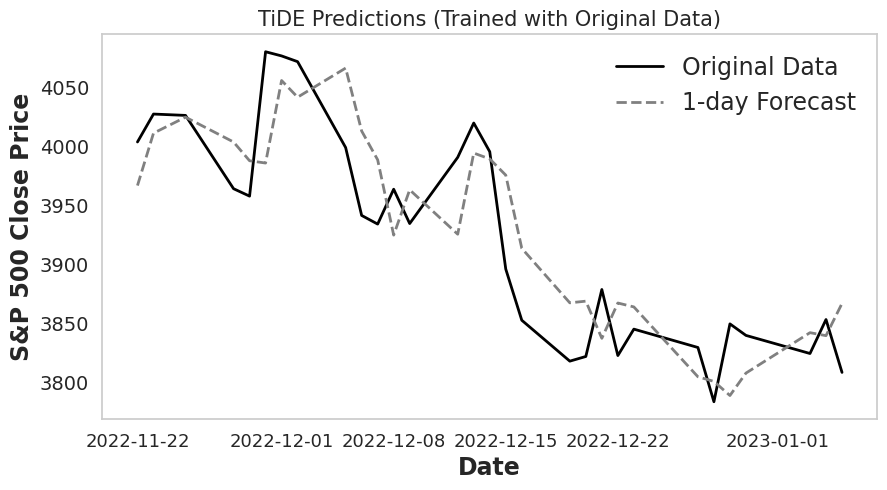


Directional Movement Metrics:

TiDE (Original) | Train Accuracy: 53.39%
TiDE (Original) | Validation Accuracy: 53.82%
TiDE (Original) | Test Accuracy: 51.45%
TiDE (Original) | Recall: 56.16%
TiDE (Original) | Precision (Rise): 53.95%
TiDE (Original) | Precision (Fall): 48.39%
TiDE (Original) | F1 Score: 55.03%


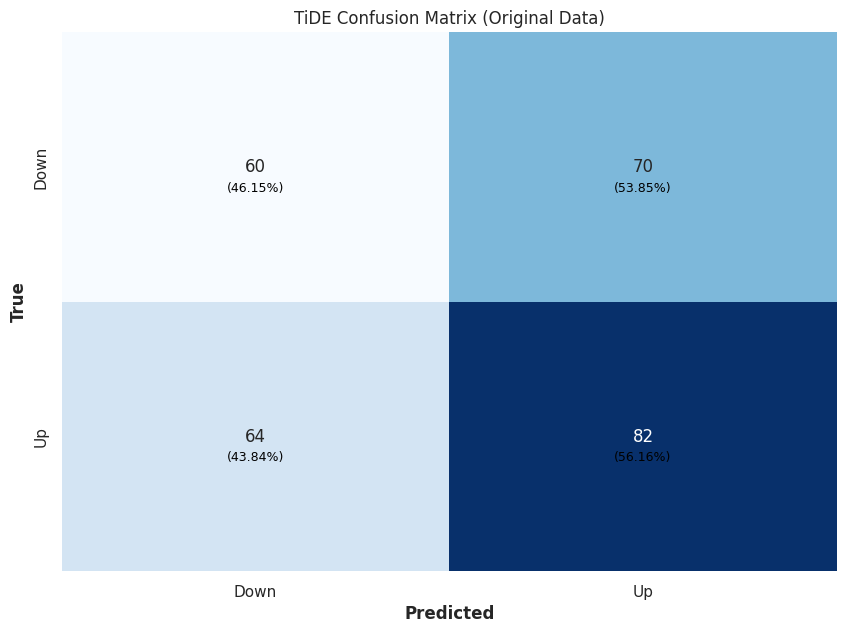

In [ ]:
model = get_model_tide()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

TiDE (Denoised) | MAE: 23.31
TiDE (Denoised) | MSE: 865.17
TiDE (Denoised) | RMSE: 29.41
TiDE (Denoised) | RMSSE: 0.81
TiDE (Denoised) | MAPE: 0.56%
TiDE (Denoised) | MASE: 0.82
TiDE (Denoised) | R2: 0.99


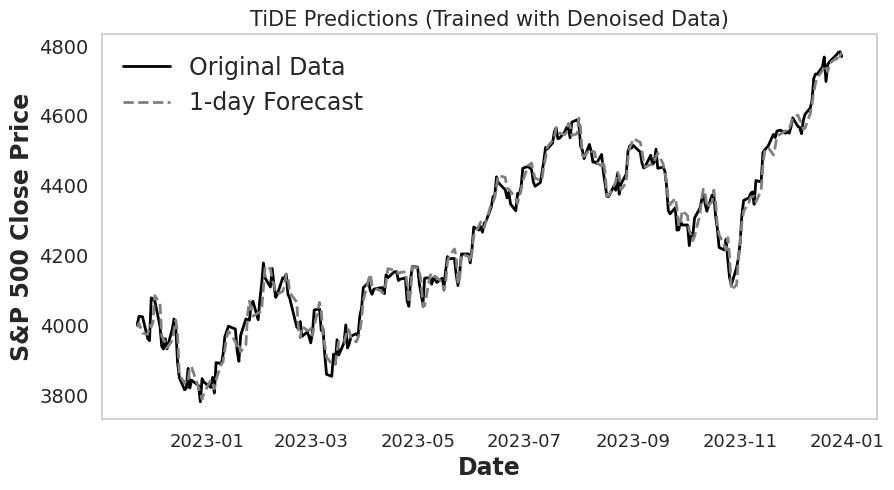

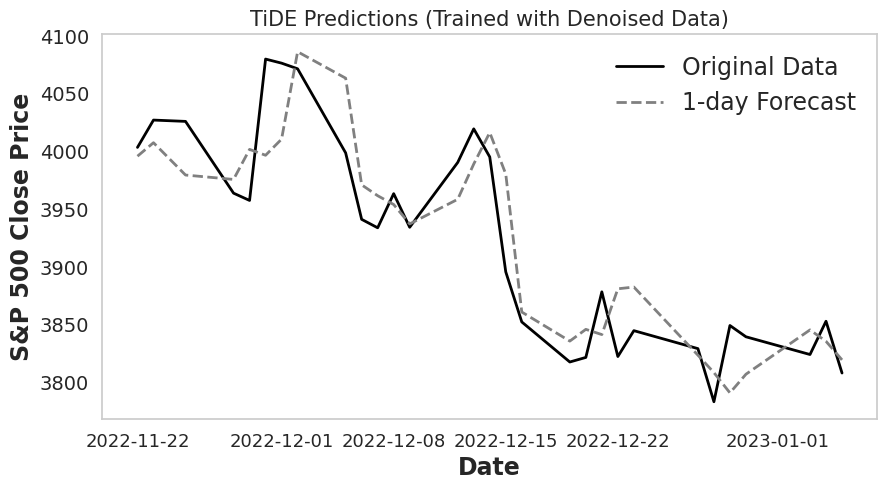


Directional Movement Metrics:

TiDE (Denoised) | Train Accuracy: 67.55%
TiDE (Denoised) | Validation Accuracy: 68.36%
TiDE (Denoised) | Test Accuracy: 64.86%
TiDE (Denoised) | Recall: 67.81%
TiDE (Denoised) | Precision (Rise): 66.44%
TiDE (Denoised) | Precision (Fall): 62.99%
TiDE (Denoised) | F1 Score: 67.12%


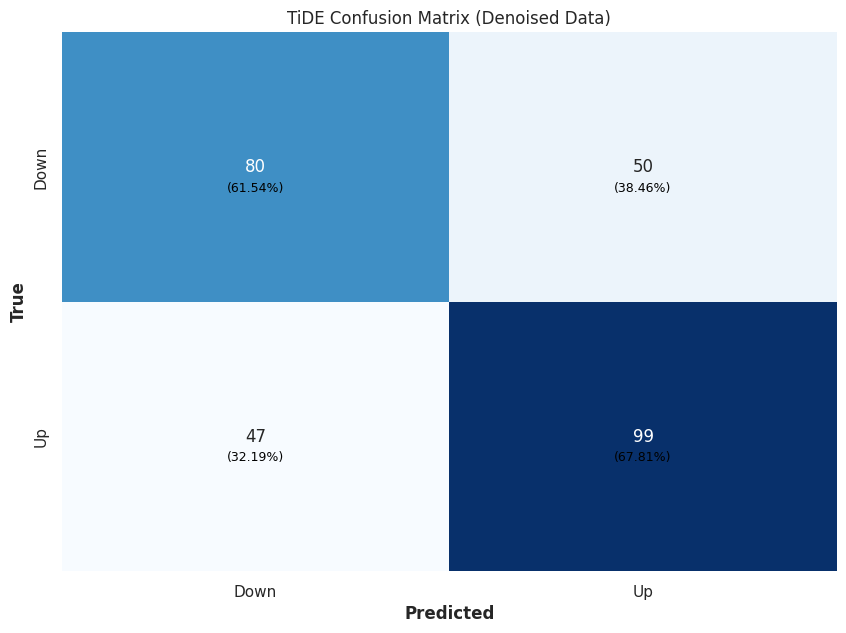

In [ ]:
model = get_model_tide()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-HiTS

**Neural Hierarchical Interpolation for Time Series Forecasting**

References:

- Paper (2022): https://doi.org/10.48550/arXiv.2201.12886
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nhits.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Original) | MAE: 45.41
N-HiTS (Original) | MSE: 3404.14
N-HiTS (Original) | RMSE: 58.34
N-HiTS (Original) | RMSSE: 1.61
N-HiTS (Original) | MAPE: 1.08%
N-HiTS (Original) | MASE: 1.60
N-HiTS (Original) | R2: 0.94


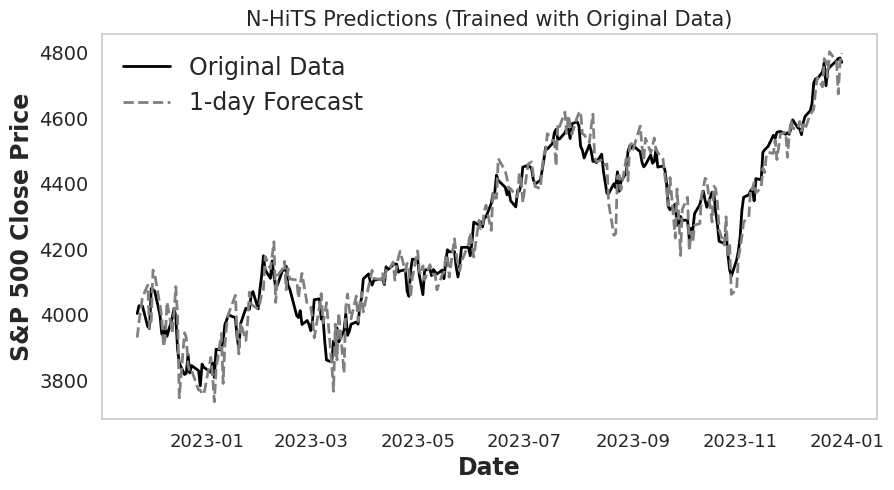

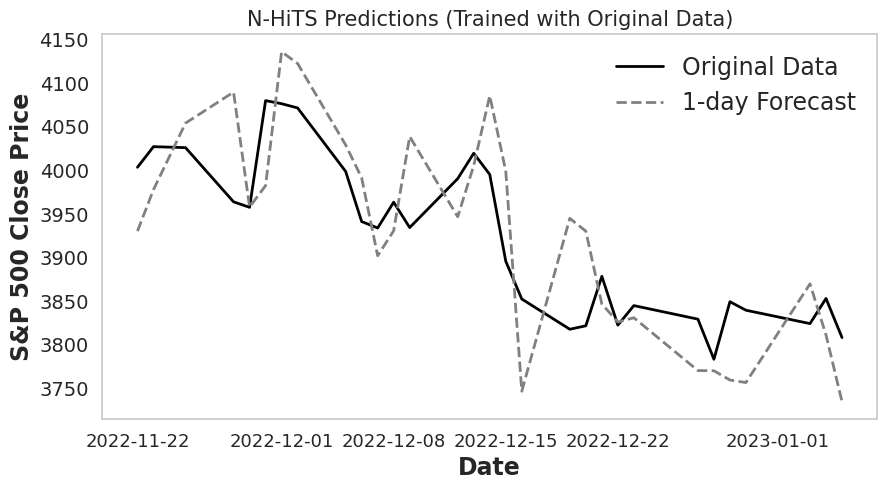


Directional Movement Metrics:

N-HiTS (Original) | Train Accuracy: 48.68%
N-HiTS (Original) | Validation Accuracy: 57.45%
N-HiTS (Original) | Test Accuracy: 50.72%
N-HiTS (Original) | Recall: 52.74%
N-HiTS (Original) | Precision (Rise): 53.47%
N-HiTS (Original) | Precision (Fall): 47.73%
N-HiTS (Original) | F1 Score: 53.10%


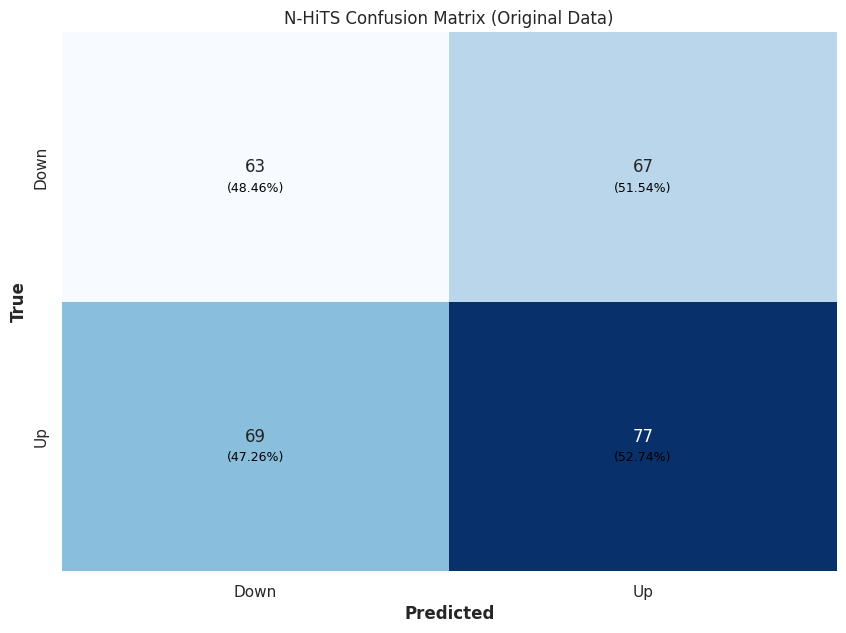

In [ ]:
model = get_model_nhits()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Denoised) | MAE: 33.96
N-HiTS (Denoised) | MSE: 1835.65
N-HiTS (Denoised) | RMSE: 42.84
N-HiTS (Denoised) | RMSSE: 1.18
N-HiTS (Denoised) | MAPE: 0.81%
N-HiTS (Denoised) | MASE: 1.20
N-HiTS (Denoised) | R2: 0.97


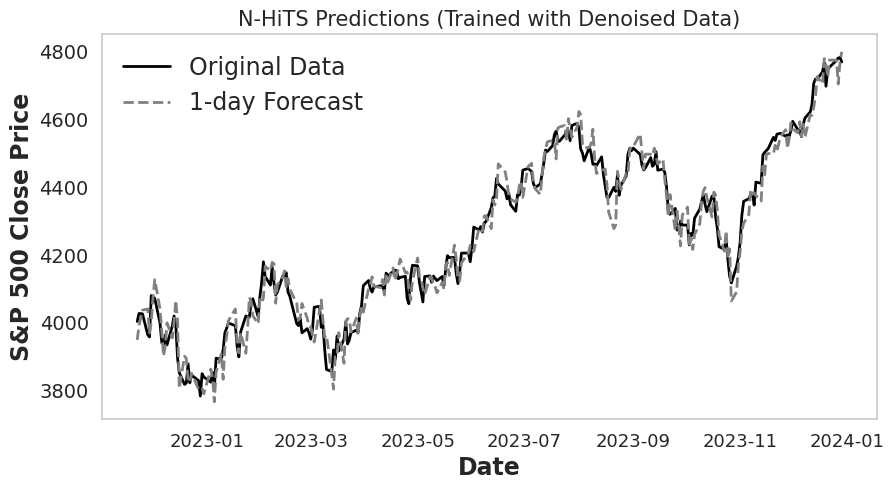

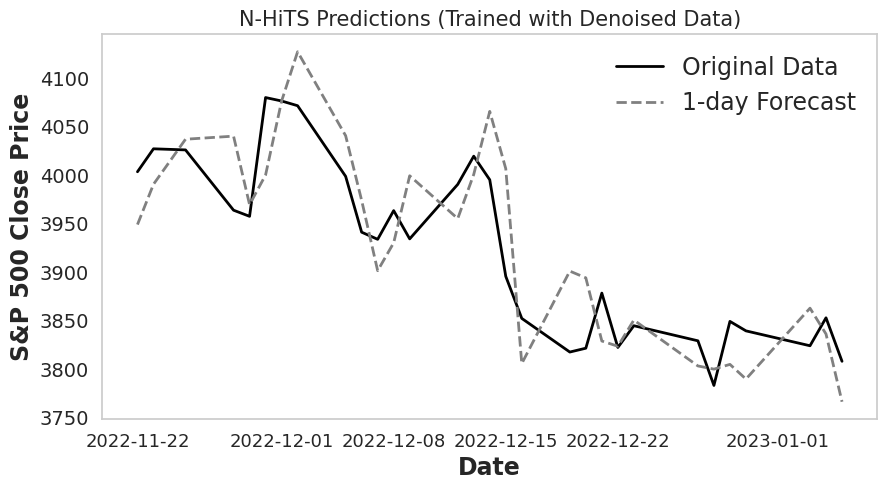


Directional Movement Metrics:

N-HiTS (Denoised) | Train Accuracy: 56.38%
N-HiTS (Denoised) | Validation Accuracy: 64.36%
N-HiTS (Denoised) | Test Accuracy: 56.52%
N-HiTS (Denoised) | Recall: 56.85%
N-HiTS (Denoised) | Precision (Rise): 59.29%
N-HiTS (Denoised) | Precision (Fall): 53.68%
N-HiTS (Denoised) | F1 Score: 58.04%


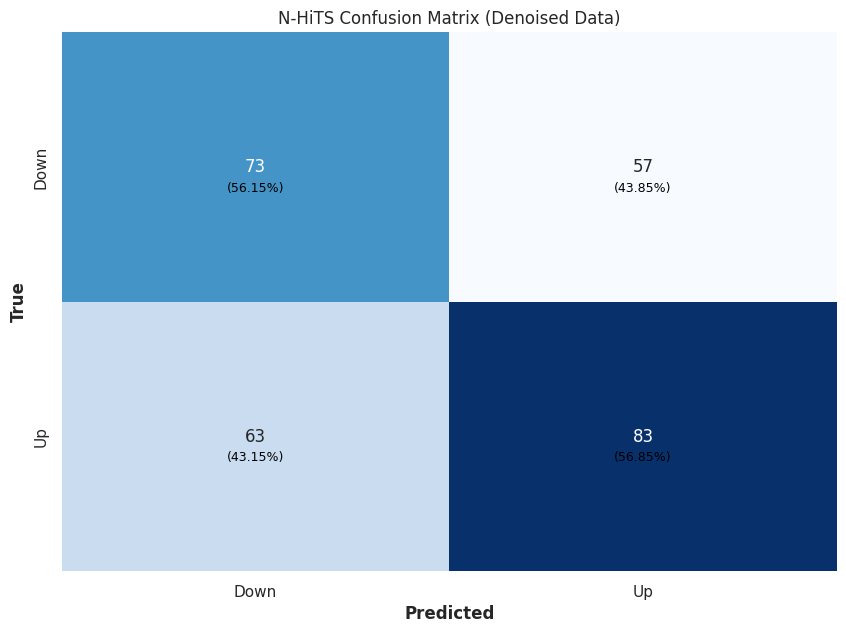

In [ ]:
model = get_model_nhits()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TSMixer

TimeSeries Mixer Model

**References**:
- Paper (2023): https://doi.org/10.48550/arXiv.2303.06053
- Code: https://github.com/ditschuk/pytorch-tsmixer
- Darts documentation: https://unit8co.github.io/darts/examples/21-TSMixer-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Original) | MAE: 90.66
TSMixer (Original) | MSE: 15021.84
TSMixer (Original) | RMSE: 122.56
TSMixer (Original) | RMSSE: 3.38
TSMixer (Original) | MAPE: 2.15%
TSMixer (Original) | MASE: 3.19
TSMixer (Original) | R2: 0.75


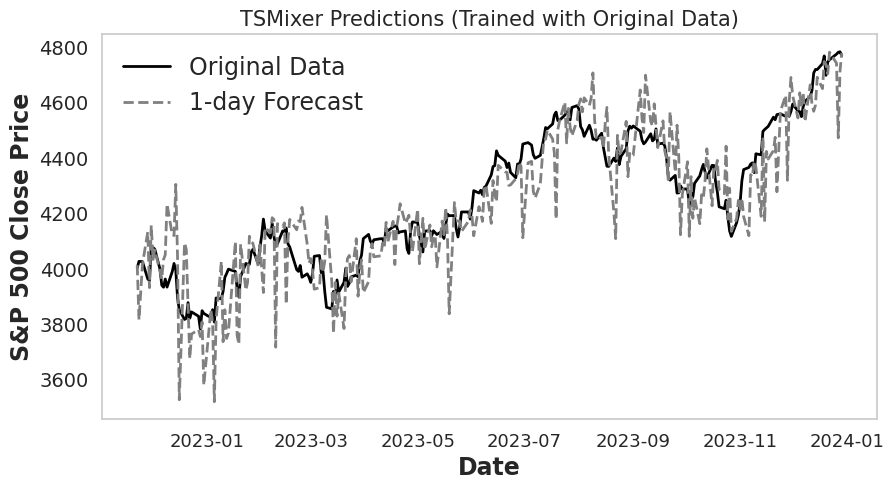

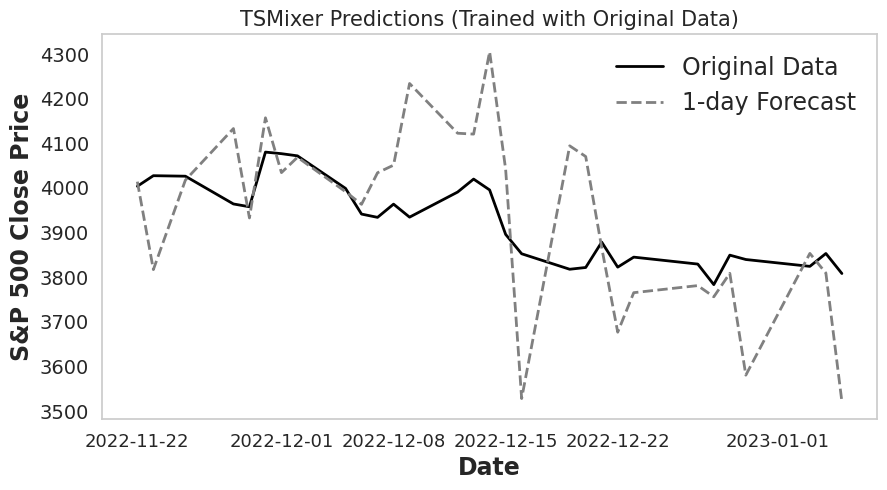


Directional Movement Metrics:

TSMixer (Original) | Train Accuracy: 48.91%
TSMixer (Original) | Validation Accuracy: 56.00%
TSMixer (Original) | Test Accuracy: 46.38%
TSMixer (Original) | Recall: 47.26%
TSMixer (Original) | Precision (Rise): 49.29%
TSMixer (Original) | Precision (Fall): 43.38%
TSMixer (Original) | F1 Score: 48.25%


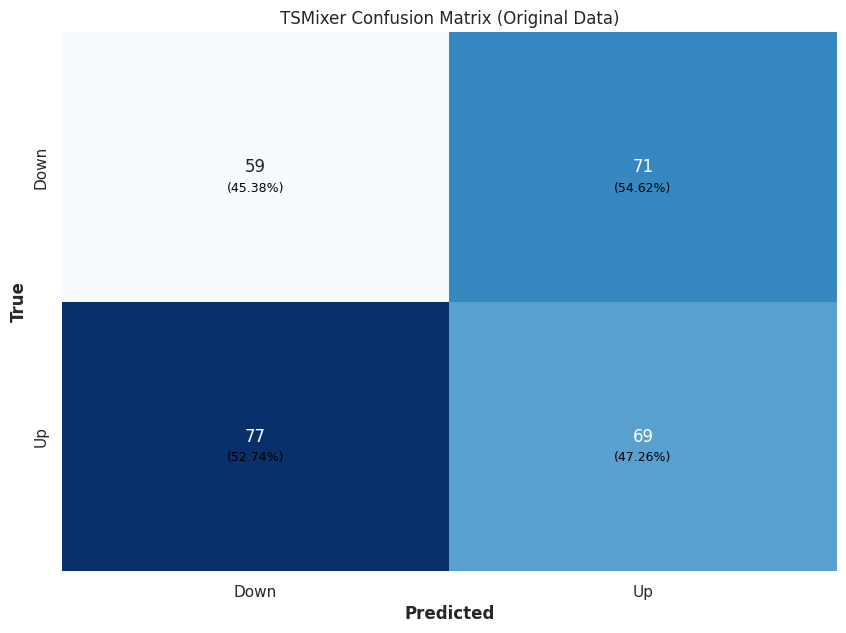

In [ ]:
model = get_model_tsm()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Denoised) | MAE: 85.58
TSMixer (Denoised) | MSE: 13163.98
TSMixer (Denoised) | RMSE: 114.73
TSMixer (Denoised) | RMSSE: 3.16
TSMixer (Denoised) | MAPE: 2.03%
TSMixer (Denoised) | MASE: 3.02
TSMixer (Denoised) | R2: 0.78


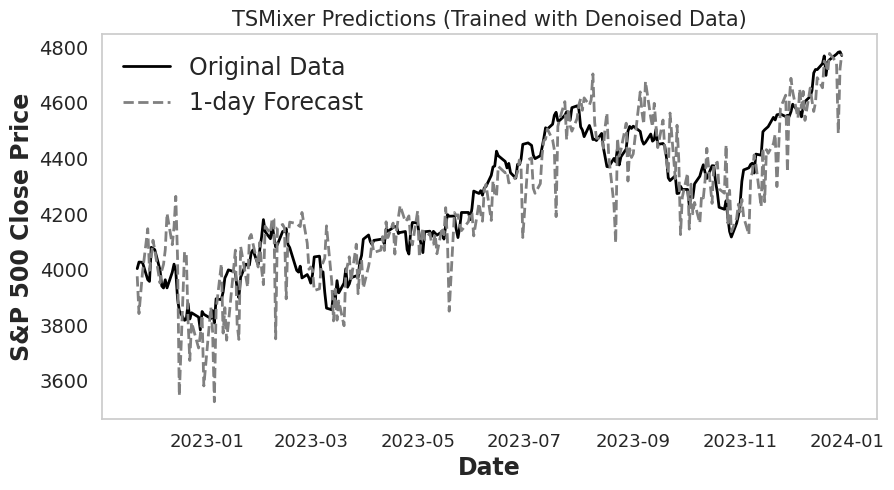

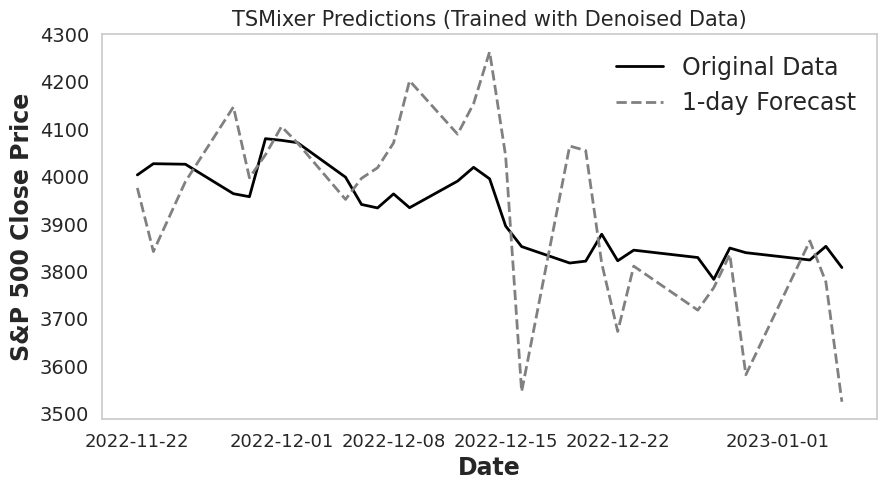


Directional Movement Metrics:

TSMixer (Denoised) | Train Accuracy: 49.80%
TSMixer (Denoised) | Validation Accuracy: 56.36%
TSMixer (Denoised) | Test Accuracy: 47.83%
TSMixer (Denoised) | Recall: 49.32%
TSMixer (Denoised) | Precision (Rise): 50.70%
TSMixer (Denoised) | Precision (Fall): 44.78%
TSMixer (Denoised) | F1 Score: 50.00%


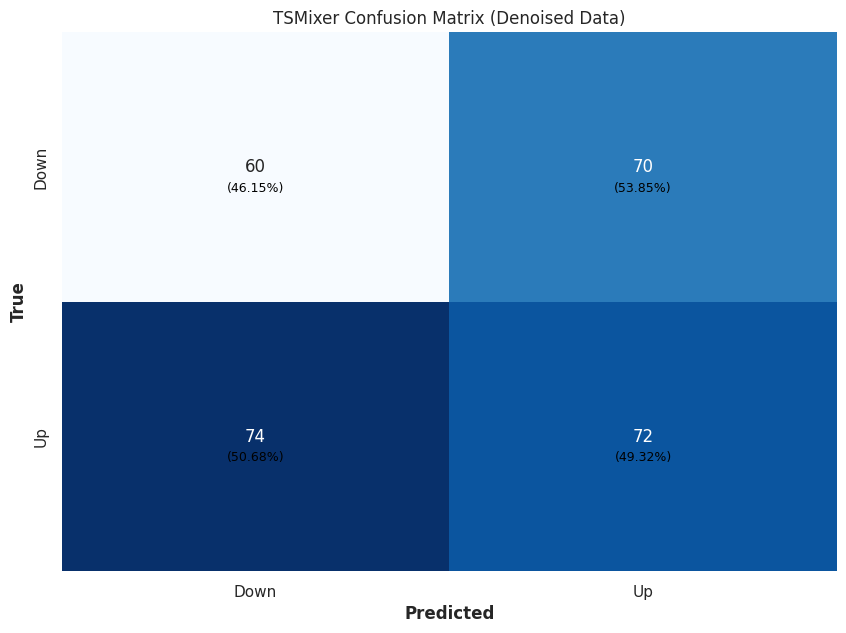

In [ ]:
model = get_model_tsm()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- xLSTM Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

In [ ]:
from ml.models.xlstm_ts.xlstm_ts_model import *
from ml.models.xlstm_ts.logic import *

In [ ]:
plot_architecture_xlstm()

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


#### Training and evaluation

In [ ]:
model_name = 'xLSTM-TS'

**Not denoised**

Epoch [1/200], Loss: 0.00235380, Validation Loss: 0.00086862
Epoch [2/200], Loss: 0.00257526, Validation Loss: 0.00079773
Epoch [3/200], Loss: 0.00455137, Validation Loss: 0.00150476
Epoch [4/200], Loss: 0.00072003, Validation Loss: 0.00051164
Epoch [5/200], Loss: 0.00087667, Validation Loss: 0.00049170
Epoch [6/200], Loss: 0.00132743, Validation Loss: 0.00081783
Epoch [7/200], Loss: 0.00313928, Validation Loss: 0.00185307
Epoch [8/200], Loss: 0.00059135, Validation Loss: 0.00043280
Epoch [9/200], Loss: 0.00150168, Validation Loss: 0.00095229
Epoch [10/200], Loss: 0.00045525, Validation Loss: 0.00035378
Epoch [11/200], Loss: 0.00159513, Validation Loss: 0.00105438
Epoch [12/200], Loss: 0.00083749, Validation Loss: 0.00039551
Epoch [13/200], Loss: 0.00030666, Validation Loss: 0.00028604
Epoch [14/200], Loss: 0.00057557, Validation Loss: 0.00030185
Epoch [15/200], Loss: 0.00045536, Validation Loss: 0.00029152
Epoch [16/200], Loss: 0.00080792, Validation Loss: 0.00037976
Epoch [17/200], L

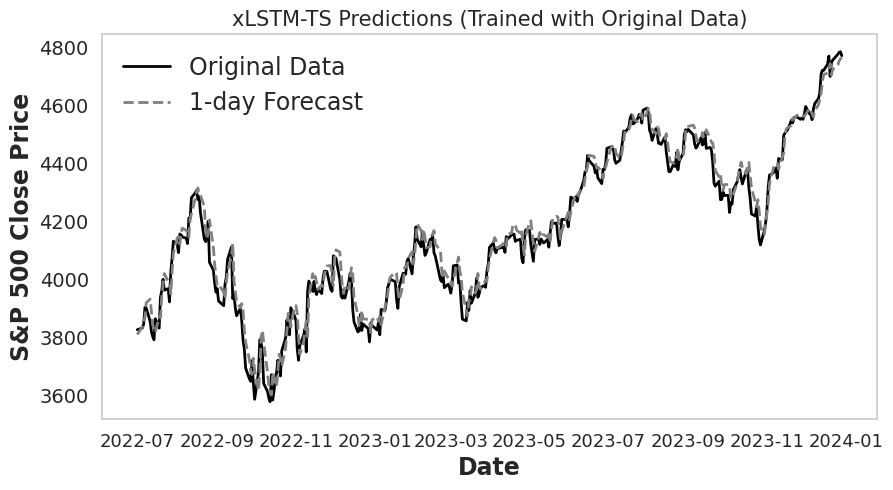

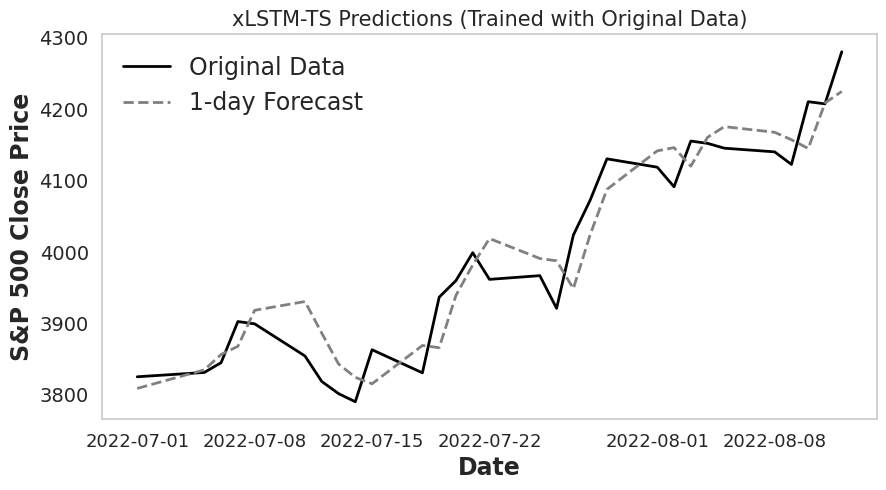

xLSTM-TS (Original) | Train Accuracy: 48.10%
xLSTM-TS (Original) | Validation Accuracy: 49.87%
xLSTM-TS (Original) | Test Accuracy: 49.47%
xLSTM-TS (Original) | Recall: 53.68%
xLSTM-TS (Original) | Precision (Rise): 50.00%
xLSTM-TS (Original) | Precision (Fall): 48.84%
xLSTM-TS (Original) | F1 Score: 51.78%


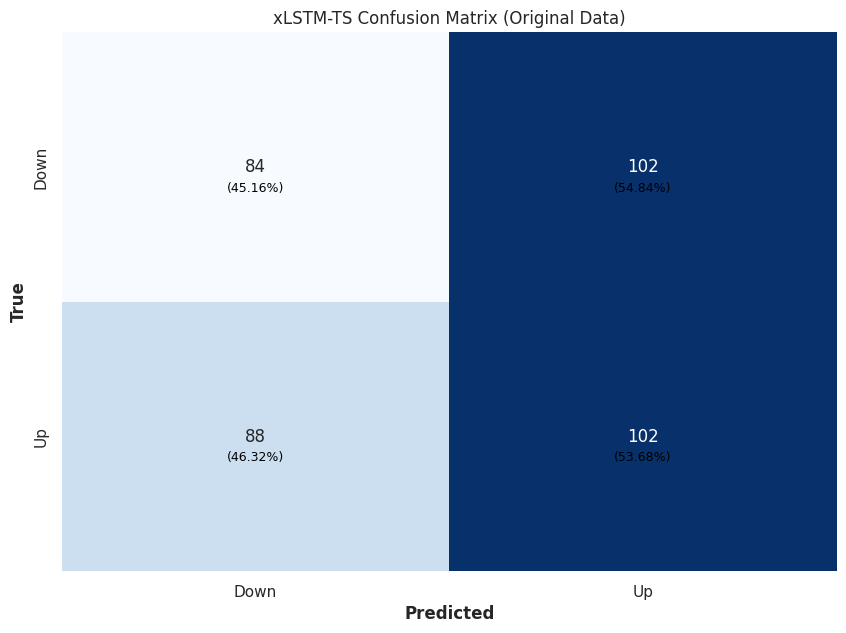

In [ ]:
results_df, metrics = run_xlstm_ts(train_X, train_y, val_X, val_y, test_X, test_y, scaler, STOCK, 'Original', test_dates)

In [ ]:
metrics_accumulator[model_name] = metrics

**Denoised**

Epoch [1/200], Loss: 0.00201041, Validation Loss: 0.00088980
Epoch [2/200], Loss: 0.00100479, Validation Loss: 0.00106107
Epoch [3/200], Loss: 0.00251091, Validation Loss: 0.00057404
Epoch [4/200], Loss: 0.00200595, Validation Loss: 0.00046368
Epoch [5/200], Loss: 0.00247626, Validation Loss: 0.00054477
Epoch [6/200], Loss: 0.00063576, Validation Loss: 0.00042531
Epoch [7/200], Loss: 0.00046105, Validation Loss: 0.00043702
Epoch [8/200], Loss: 0.00094729, Validation Loss: 0.00027504
Epoch [9/200], Loss: 0.00132817, Validation Loss: 0.00063964
Epoch [10/200], Loss: 0.00067151, Validation Loss: 0.00027986
Epoch [11/200], Loss: 0.00144627, Validation Loss: 0.00090573
Epoch [12/200], Loss: 0.00066630, Validation Loss: 0.00037402
Epoch [13/200], Loss: 0.00103836, Validation Loss: 0.00073780
Epoch [14/200], Loss: 0.00043621, Validation Loss: 0.00027128
Epoch [15/200], Loss: 0.00040679, Validation Loss: 0.00019726
Epoch [16/200], Loss: 0.00097632, Validation Loss: 0.00059880
Epoch [17/200], L

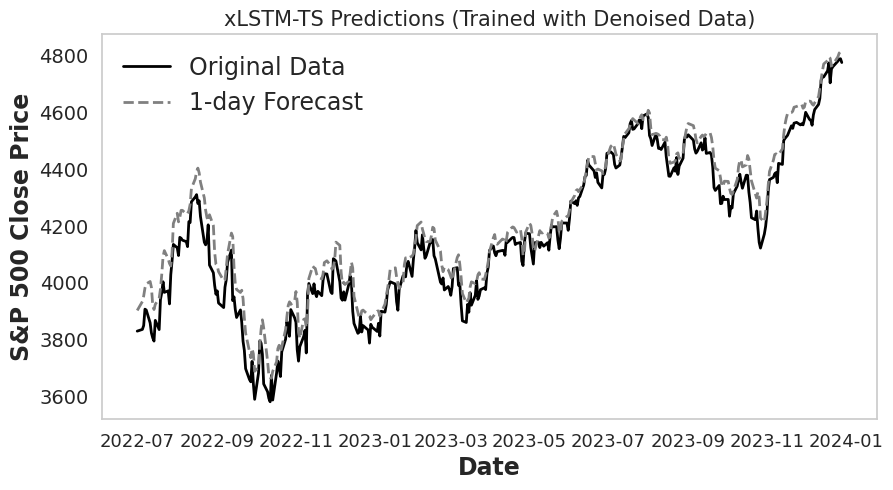

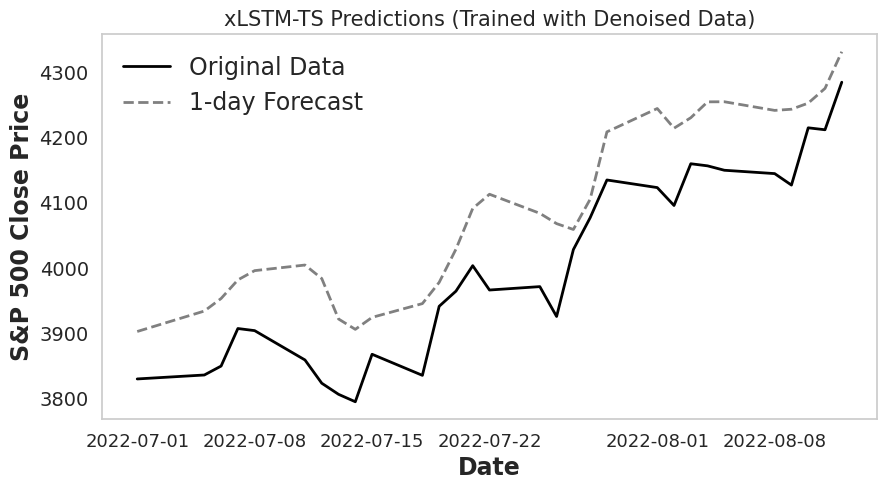

xLSTM-TS (Denoised) | Train Accuracy: 64.21%
xLSTM-TS (Denoised) | Validation Accuracy: 64.80%
xLSTM-TS (Denoised) | Test Accuracy: 66.22%
xLSTM-TS (Denoised) | Recall: 72.11%
xLSTM-TS (Denoised) | Precision (Rise): 64.93%
xLSTM-TS (Denoised) | Precision (Fall): 67.88%
xLSTM-TS (Denoised) | F1 Score: 68.33%


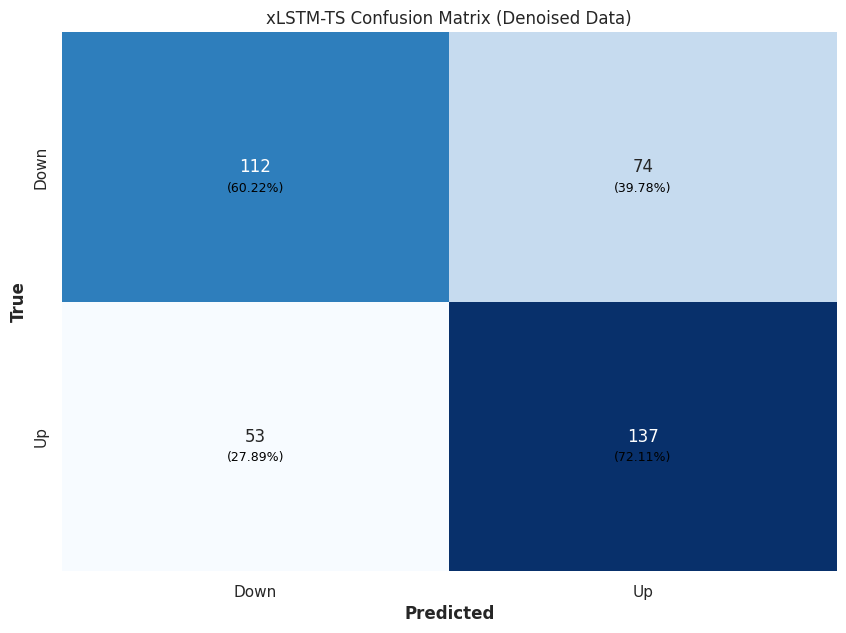

In [ ]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y, scaler_denoised, STOCK, 'Denoised', test_dates, train_y, val_y, test_y)

In [ ]:
metrics_accumulator_denoised[model_name] = metrics_denoised

## Results

In [ ]:
from ml.results.results import *

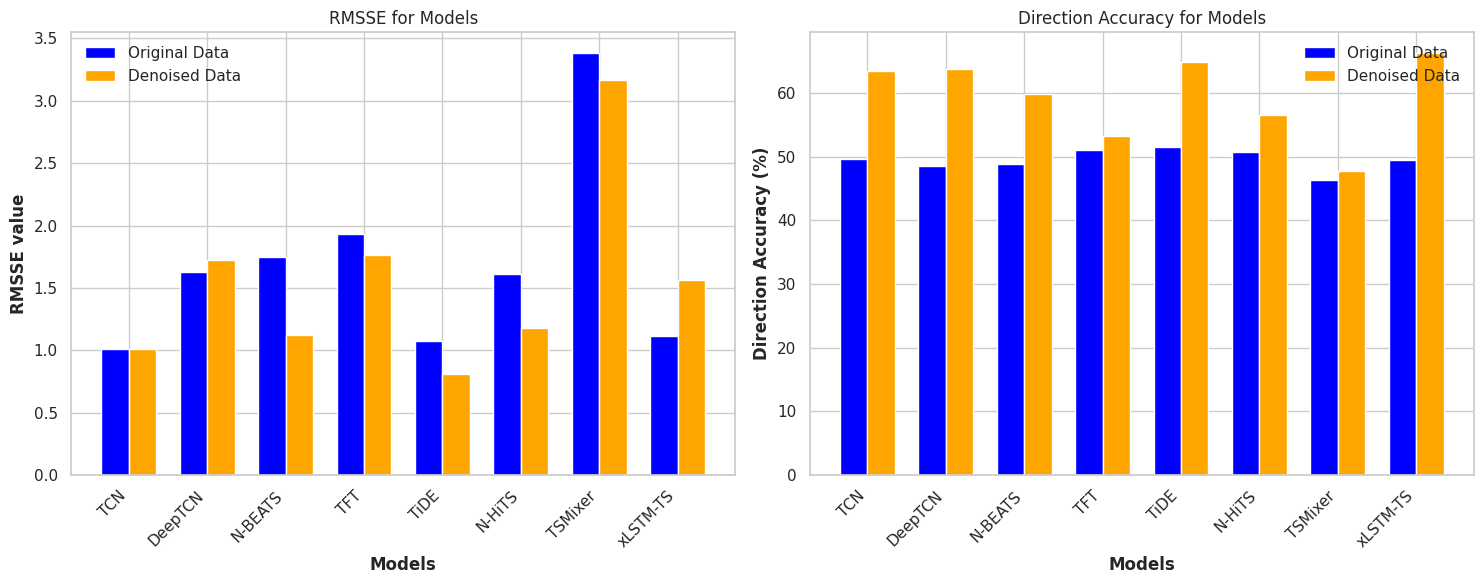

In [ ]:
final_results = display_metrics(metrics_accumulator, metrics_accumulator_denoised)

In [ ]:
original_data = show_results(final_results, 'Original')
denoised_data = show_results(final_results, 'Denoised')

In [ ]:
original_data

MAE       MSE    RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  \
TCN       29.03   1336.56   36.56   1.01  0.69%  1.02  0.98        49.64%   
DeepTCN   50.08   3471.25   58.92   1.62  1.18%  1.76  0.94        48.55%   
N-BEATS   50.18   4029.71   63.48   1.75  1.19%  1.77  0.93        48.91%   
TFT       52.56   4924.10   70.17   1.93  1.25%  1.85  0.92        51.09%   
TiDE      31.43   1512.92   38.90   1.07  0.75%  1.11  0.97        51.45%   
N-HiTS    45.41   3404.14   58.34   1.61  1.08%  1.60  0.94        50.72%   
TSMixer   90.66  15021.84  122.56   3.38  2.15%  3.19  0.75        46.38%   
xLSTM-TS  38.25   2325.60   48.22   1.11  0.94%  1.16  0.97        49.47%   

          Recall Precision (Rise) Precision (Fall) F1 Score  \
TCN       53.42%           52.35%           46.46%   52.88%   
DeepTCN   51.37%           51.37%           45.38%   51.37%   
N-BEATS   48.63%           51.82%           46.04%   50.18%   
TFT       52.74%           53.85%           48.12%   53.29%   
TiDE      56.16%           53.95%           48.39%   55.03%   
N-HiTS    52.74%           53.47%           47.73%   53.10%   
TSMixer   47.26%           49.29%           43.38%   48.25%   
xLSTM-TS  53.68%           50.00%           48.84%   51.78%   

         Validation Accuracy Train Accuracy  
TCN                   49.09%         47.83%  
DeepTCN               50.55%         47.06%  
N-BEATS               57.82%         50.03%  
TFT                   59.27%         48.31%  
TiDE                  53.82%         53.39%  
N-HiTS                57.45%         48.68%  
TSMixer               56.00%         48.91%  
xLSTM-TS              49.87%         48.10%

In [ ]:
denoised_data

MAE       MSE    RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  \
TCN       30.01   1333.10   36.51   1.01  0.71%  1.06  0.98        63.41%   
DeepTCN   54.97   3924.06   62.64   1.73  1.29%  1.94  0.93        63.77%   
N-BEATS   32.14   1666.18   40.82   1.13  0.76%  1.13  0.97        59.78%   
TFT       47.97   4100.21   64.03   1.77  1.14%  1.69  0.93        53.26%   
TiDE      23.31    865.17   29.41   0.81  0.56%  0.82  0.99        64.86%   
N-HiTS    33.96   1835.65   42.84   1.18  0.81%  1.20  0.97        56.52%   
TSMixer   85.58  13163.98  114.73   3.16  2.03%  3.02  0.78        47.83%   
xLSTM-TS  55.84   4600.42   67.83   1.56  1.37%  1.69  0.94        66.22%   

          Recall Precision (Rise) Precision (Fall) F1 Score  \
TCN       69.86%           64.15%           62.39%   66.89%   
DeepTCN   71.23%           64.20%           63.16%   67.53%   
N-BEATS   62.33%           61.90%           57.36%   62.12%   
TFT       54.79%           55.94%           50.38%   55.36%   
TiDE      67.81%           66.44%           62.99%   67.12%   
N-HiTS    56.85%           59.29%           53.68%   58.04%   
TSMixer   49.32%           50.70%           44.78%   50.00%   
xLSTM-TS  72.11%           64.93%           67.88%   68.33%   

         Validation Accuracy Train Accuracy  
TCN                   65.82%         64.23%  
DeepTCN               65.45%         64.65%  
N-BEATS               63.64%         58.56%  
TFT                   60.36%         52.02%  
TiDE                  68.36%         67.55%  
N-HiTS                64.36%         56.38%  
TSMixer               56.36%         49.80%  
xLSTM-TS              64.80%         64.21%

## Export

In [ ]:
results_df.head(10)

Date        Close  Predicted Value  True Label  Predicted Label
0 2022-07-01  3825.330322      3809.031250           1                1
1 2022-07-05  3831.389893      3834.990967           1                1
2 2022-07-06  3845.080078      3856.523438           1                1
3 2022-07-07  3902.620117      3867.918945           0                1
4 2022-07-08  3899.380127      3918.329834           0                1
5 2022-07-11  3854.429932      3930.624023           0                0
6 2022-07-12  3818.800293      3886.432373           0                0
7 2022-07-13  3801.780029      3843.263916           0                0
8 2022-07-14  3790.380127      3824.550293           1                0
9 2022-07-15  3863.159912      3815.536377           0                1

In [ ]:
results_denoised_df.head(10)

Date        Close  Predicted Value  True Label  Predicted Label
0 2022-07-01  3829.663086      3902.491455           1                1
1 2022-07-05  3835.731934      3933.875000           1                1
2 2022-07-06  3849.442383      3953.171631           1                1
3 2022-07-07  3907.067627      3981.675537           0                1
4 2022-07-08  3903.822754      3995.911865           0                1
5 2022-07-11  3858.805908      4004.518066           0                0
6 2022-07-12  3823.123291      3983.814453           0                0
7 2022-07-13  3806.078125      3921.709473           0                0
8 2022-07-14  3794.661133      3905.788086           1                1
9 2022-07-15  3867.548828      3924.166504           0                1

In [ ]:
# -- Save predictions as CSV --

%cd ..

save_results(results_df, results_denoised_df, FILE_NAME)

# -- Save the xLSTM-TS model --

# Rename the file
!mv xlstm-ts/xlstm_ts_model.pth xlstm_model_{FILE_NAME}.pth

# Download if necessary

/content
